Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Clear session
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [5]:
# Set Seed
SEED = 123

import os
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = 'true'
os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'

import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(SEED)
rn.seed(SEED)
tf.set_random_seed(SEED)

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

from tfdeterminism import patch
patch()

TensorFlow version 1.15.0 has been patched using tfdeterminism version 0.3.0


In [6]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [7]:
plt.rcParams["font.size"] = 18

# Preprocess

In [8]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [9]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Label proportion
    print('The positive proportion is {:.2f}'.format(runrest.sum() / runrest.shape[0]))
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [11]:
def Get_Dataset(TEST):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j])
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

In [12]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))

# Calculate SHAP value

In [13]:
import itertools
Models = ['GRU']

In [14]:
import shap
from tqdm.auto import tqdm

def calc_shap(input_data, data_pred, model):
    num_data = 1*10000 # background sample number (about 1/20)
    data_idx = numpy.random.choice(range(input_data.shape[0]), num_data, replace=False)
    print(data_idx)
    print(data_idx.shape)
    base = data_pred[data_idx].mean()
    print(f'Base: {base}')
    explainer = shap.DeepExplainer(model, input_data[data_idx])
    shap_val = numpy.zeros(input_data.shape)
    # calculate shap value of all data
    BATCH_SIZE = 100
    for idx in tqdm(range(input_data.shape[0] // BATCH_SIZE + 1)):
        if idx != input_data.shape[0] // BATCH_SIZE:
            bs = BATCH_SIZE
        else:
            bs = input_data.shape[0] % BATCH_SIZE
        input_shap = input_data[idx*BATCH_SIZE:(idx)*BATCH_SIZE+bs]
        shap_val[idx*BATCH_SIZE:(idx)*BATCH_SIZE+bs] = numpy.array(explainer.shap_values(input_shap))
    # base + sum(shap) = prediction
    print(shap_val.sum(axis=1).sum(axis=1) + base)
    print(data_pred.reshape(-1))
    return shap_val, base

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_shap_abs_mean(shap_val):
    s = numpy.mean(numpy.abs(shap_val),axis=0).reshape([31,50])
    plt.figure(figsize=(30.0, 20.0))
    sns.heatmap(s.transpose(),cmap='viridis')
    plt.xticks( numpy.arange(0.5,32.5), numpy.arange(-15,16))
    plt.yticks( numpy.arange(0.5,50.5), numpy.arange(1,51))
    plt.title("Average of absolute SHAP values")
    plt.xlabel("Frame")
    plt.ylabel("Functional areas of the cerebral cortex")
    plt.show()

TEST
Mouse 1
The positive proportion is 0.41
The positive proportion is 0.43
The positive proportion is 0.40
The positive proportion is 0.46
The positive proportion is 0.37
The positive proportion is 0.46
The positive proportion is 0.27
The positive proportion is 0.41
The positive proportion is 0.24
The positive proportion is 0.25
The positive proportion is 0.33
0.36709827


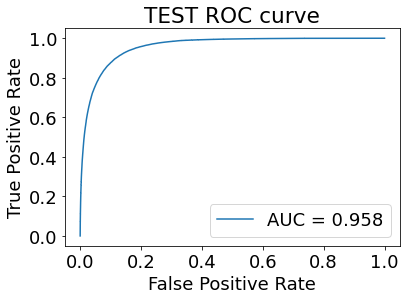

AUC: 0.958
Optimal threshold: 0.316
[ 46016  18659  42393 ... 120323  51533 188148]
(10000,)
Base: 0.36737877130508423



[0.95990976 0.95502393 0.96491285 ... 0.02771871 0.02821835 0.031966  ]
[0.95990956 0.95502424 0.9649122  ... 0.02771887 0.02821809 0.03196545]


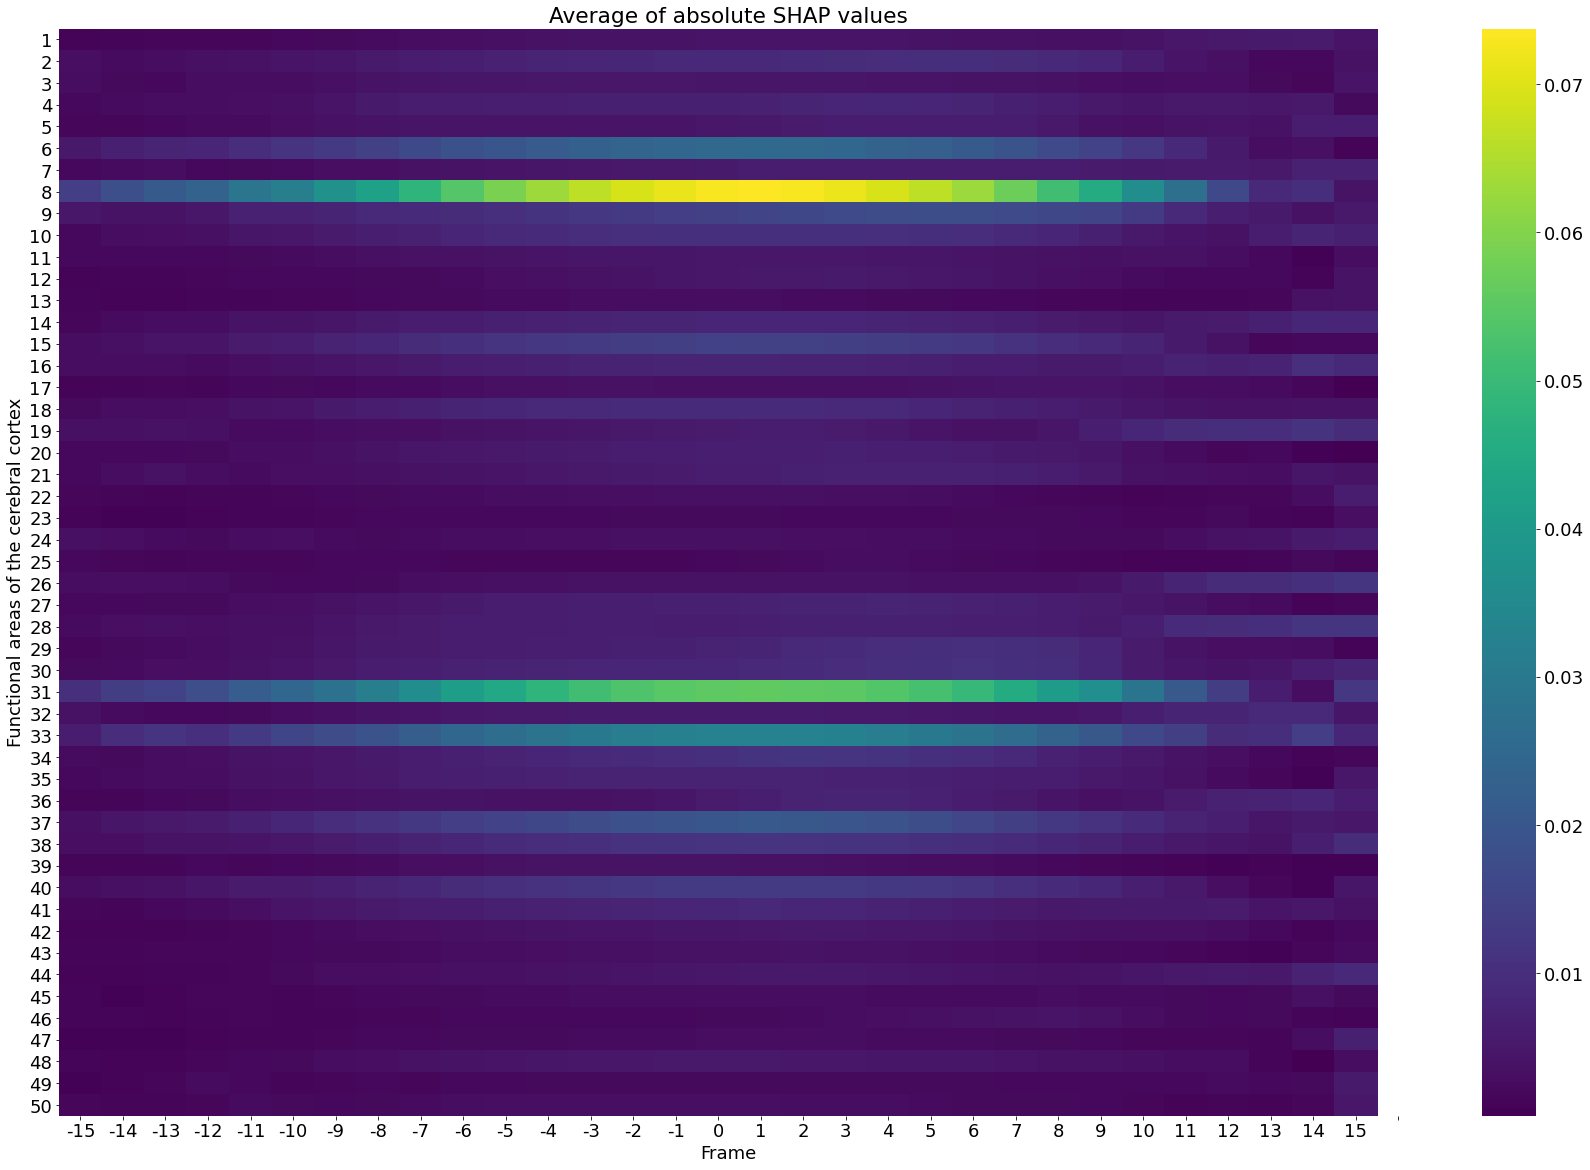

TEST
Mouse 1
The positive proportion is 0.41
The positive proportion is 0.43
The positive proportion is 0.40
The positive proportion is 0.46
The positive proportion is 0.37
The positive proportion is 0.46
The positive proportion is 0.27
The positive proportion is 0.41
The positive proportion is 0.24
The positive proportion is 0.25
The positive proportion is 0.33
0.26228166


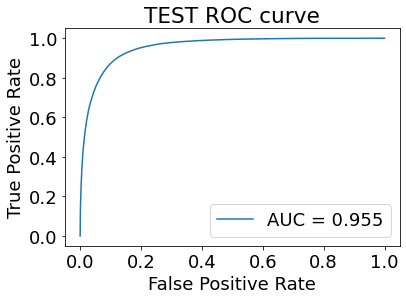

AUC: 0.955
Optimal threshold: 0.109
[130732  47539 150399 ... 127859 116915 119046]
(10000,)
Base: 0.26299595832824707



[0.69894352 0.64243672 0.7498653  ... 0.00142594 0.0015293  0.0018289 ]
[0.6989427  0.64243746 0.749867   ... 0.00142574 0.00152924 0.00182899]


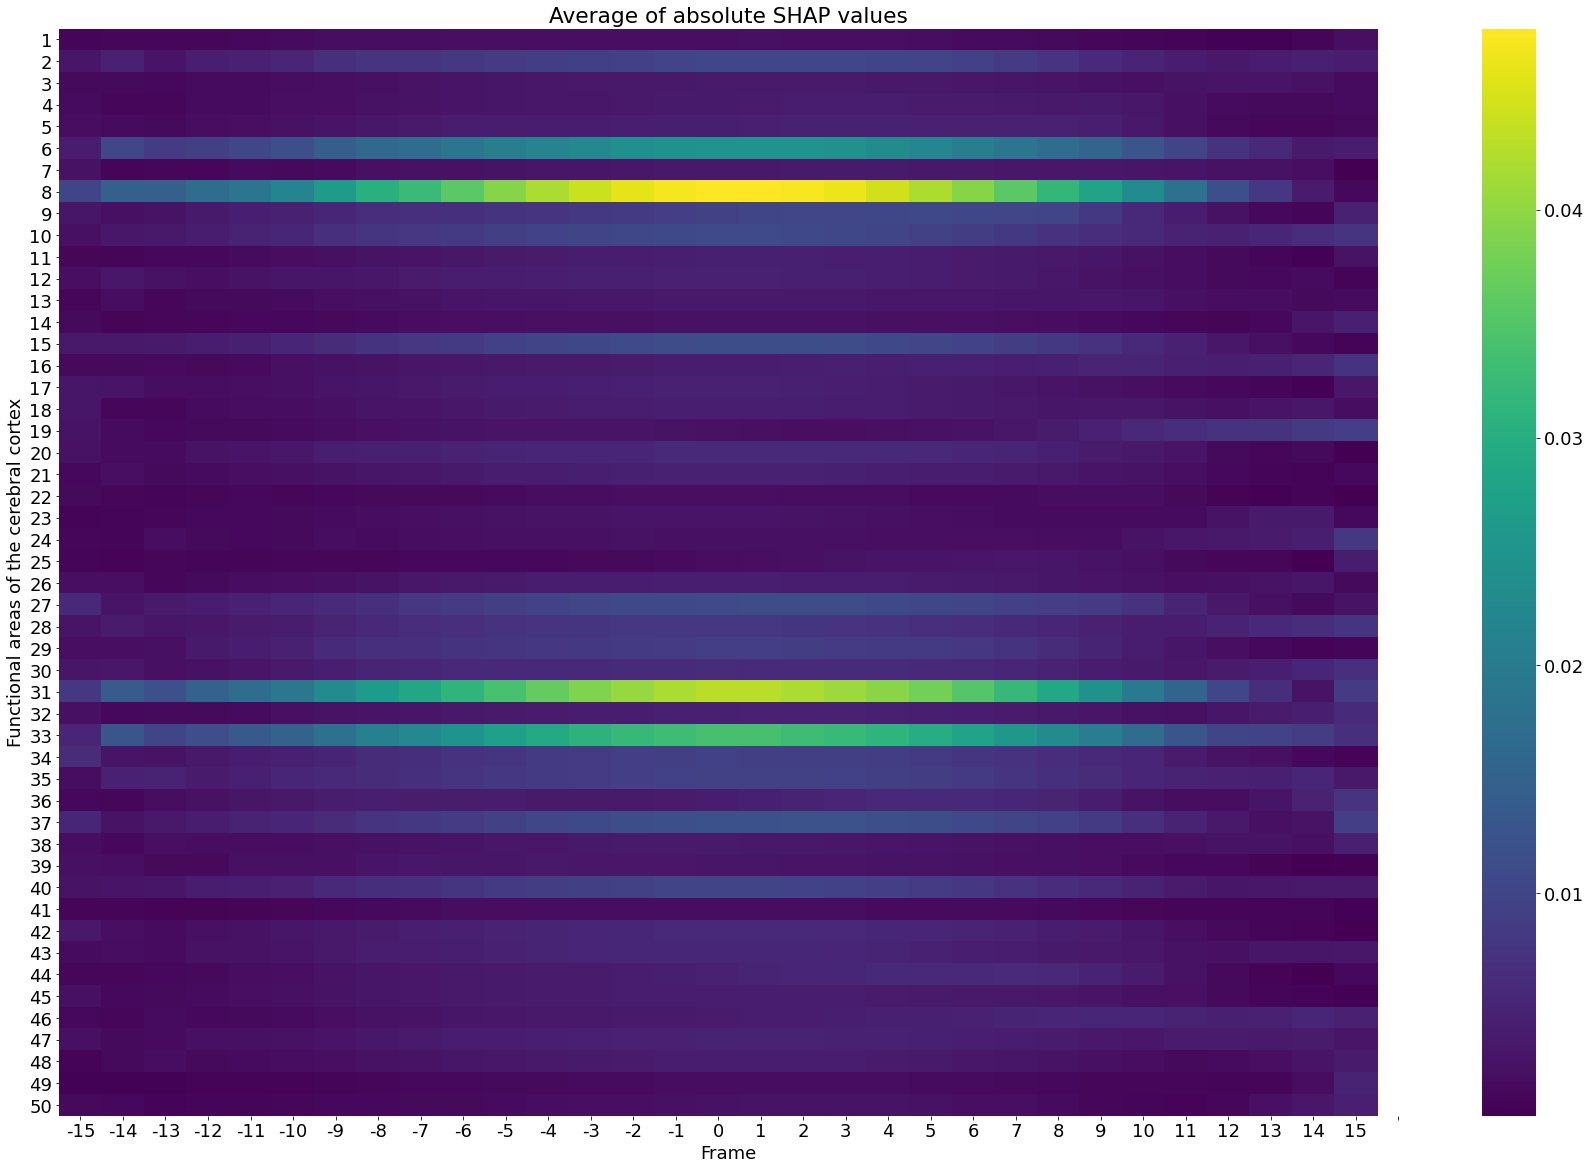

TEST
Mouse 1
The positive proportion is 0.41
The positive proportion is 0.43
The positive proportion is 0.40
The positive proportion is 0.46
The positive proportion is 0.37
The positive proportion is 0.46
The positive proportion is 0.27
The positive proportion is 0.41
The positive proportion is 0.24
The positive proportion is 0.25
The positive proportion is 0.33
0.2595999


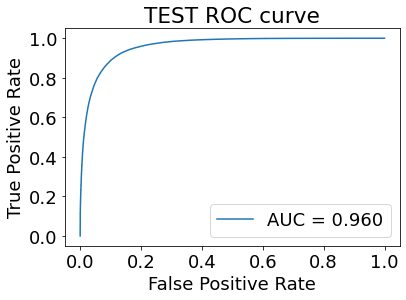

AUC: 0.960
Optimal threshold: 0.104
[181796 113260  52656 ...  12997  44789  23915]
(10000,)
Base: 0.2576902210712433



[0.76787973 0.79404048 0.81209565 ... 0.01819344 0.02664306 0.02094745]
[0.7678803  0.79404014 0.81209415 ... 0.01819387 0.02664257 0.02094776]


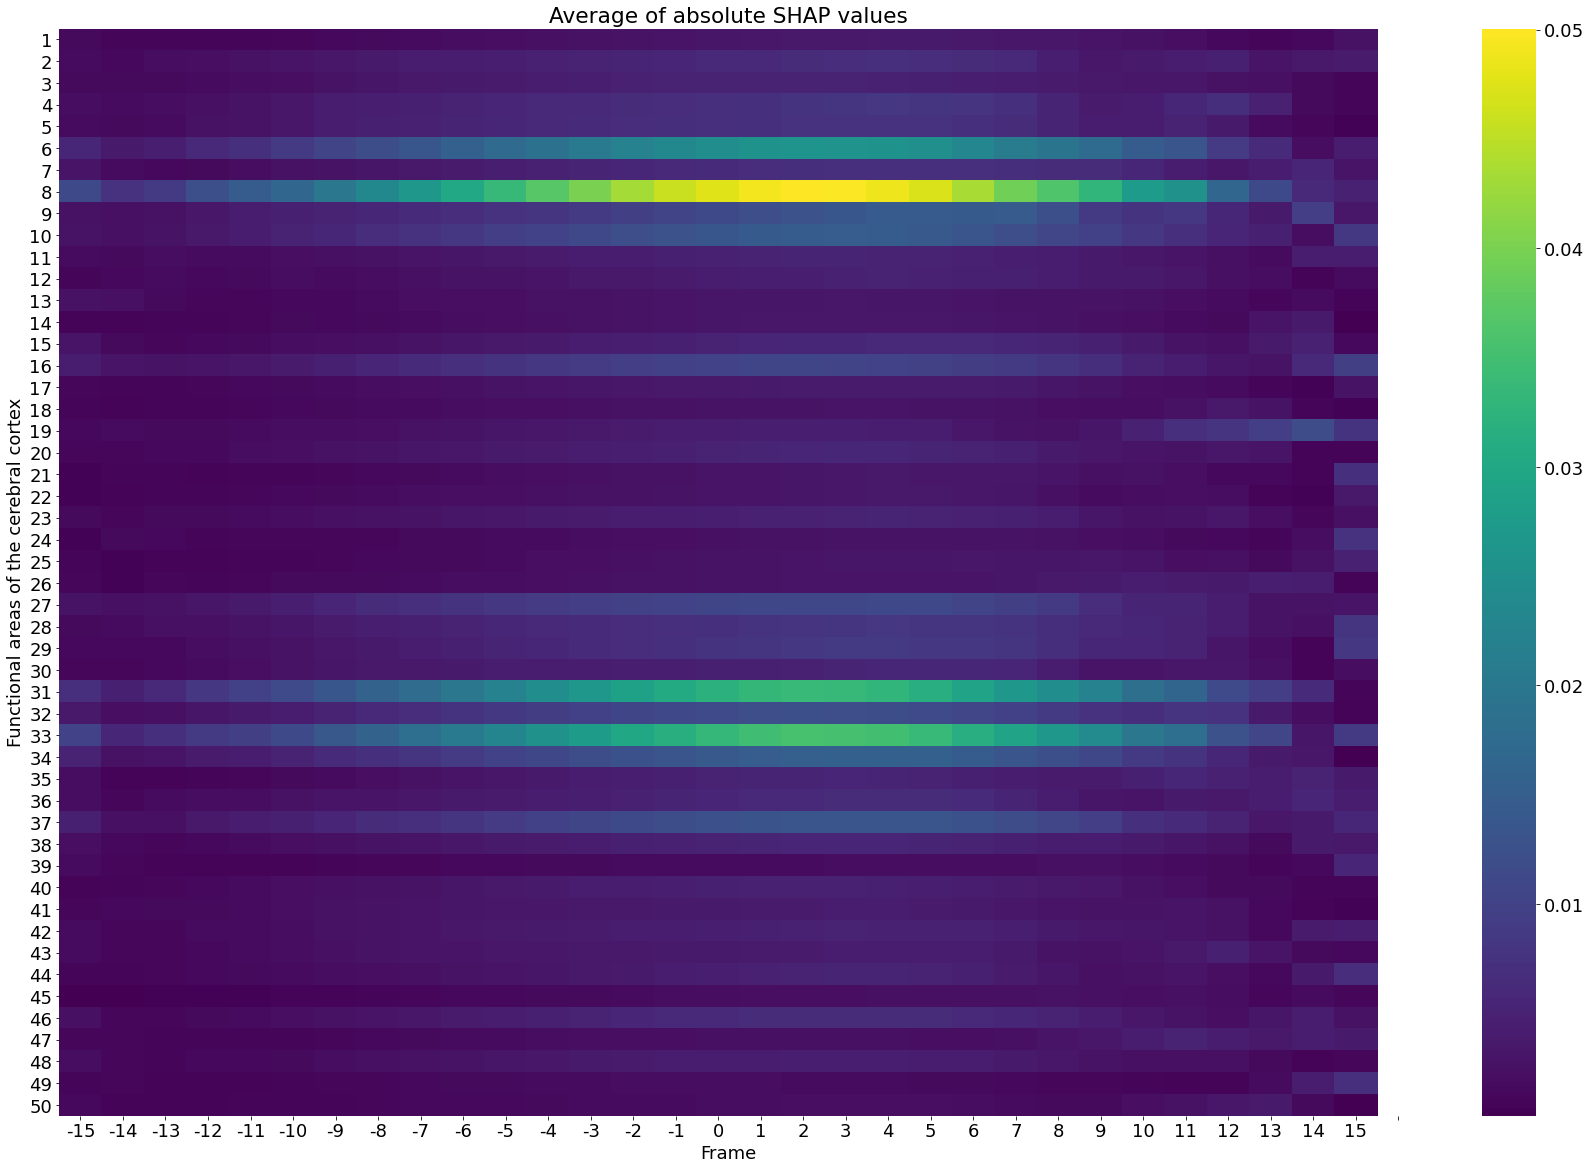

TEST
Mouse 1
The positive proportion is 0.41
The positive proportion is 0.43
The positive proportion is 0.40
The positive proportion is 0.46
The positive proportion is 0.37
The positive proportion is 0.46
The positive proportion is 0.27
The positive proportion is 0.41
The positive proportion is 0.24
The positive proportion is 0.25
The positive proportion is 0.33
0.26017907


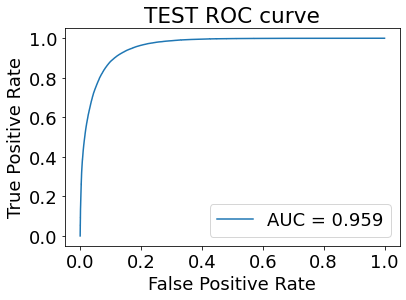

AUC: 0.959
Optimal threshold: 0.073
[184983 189790 166518 ...   3924  84010 158128]
(10000,)
Base: 0.2661958932876587



[0.49311483 0.66593438 0.7745204  ... 0.00507514 0.00793065 0.0131542 ]
[0.49311537 0.66593313 0.7745192  ... 0.0050754  0.00793042 0.01315414]


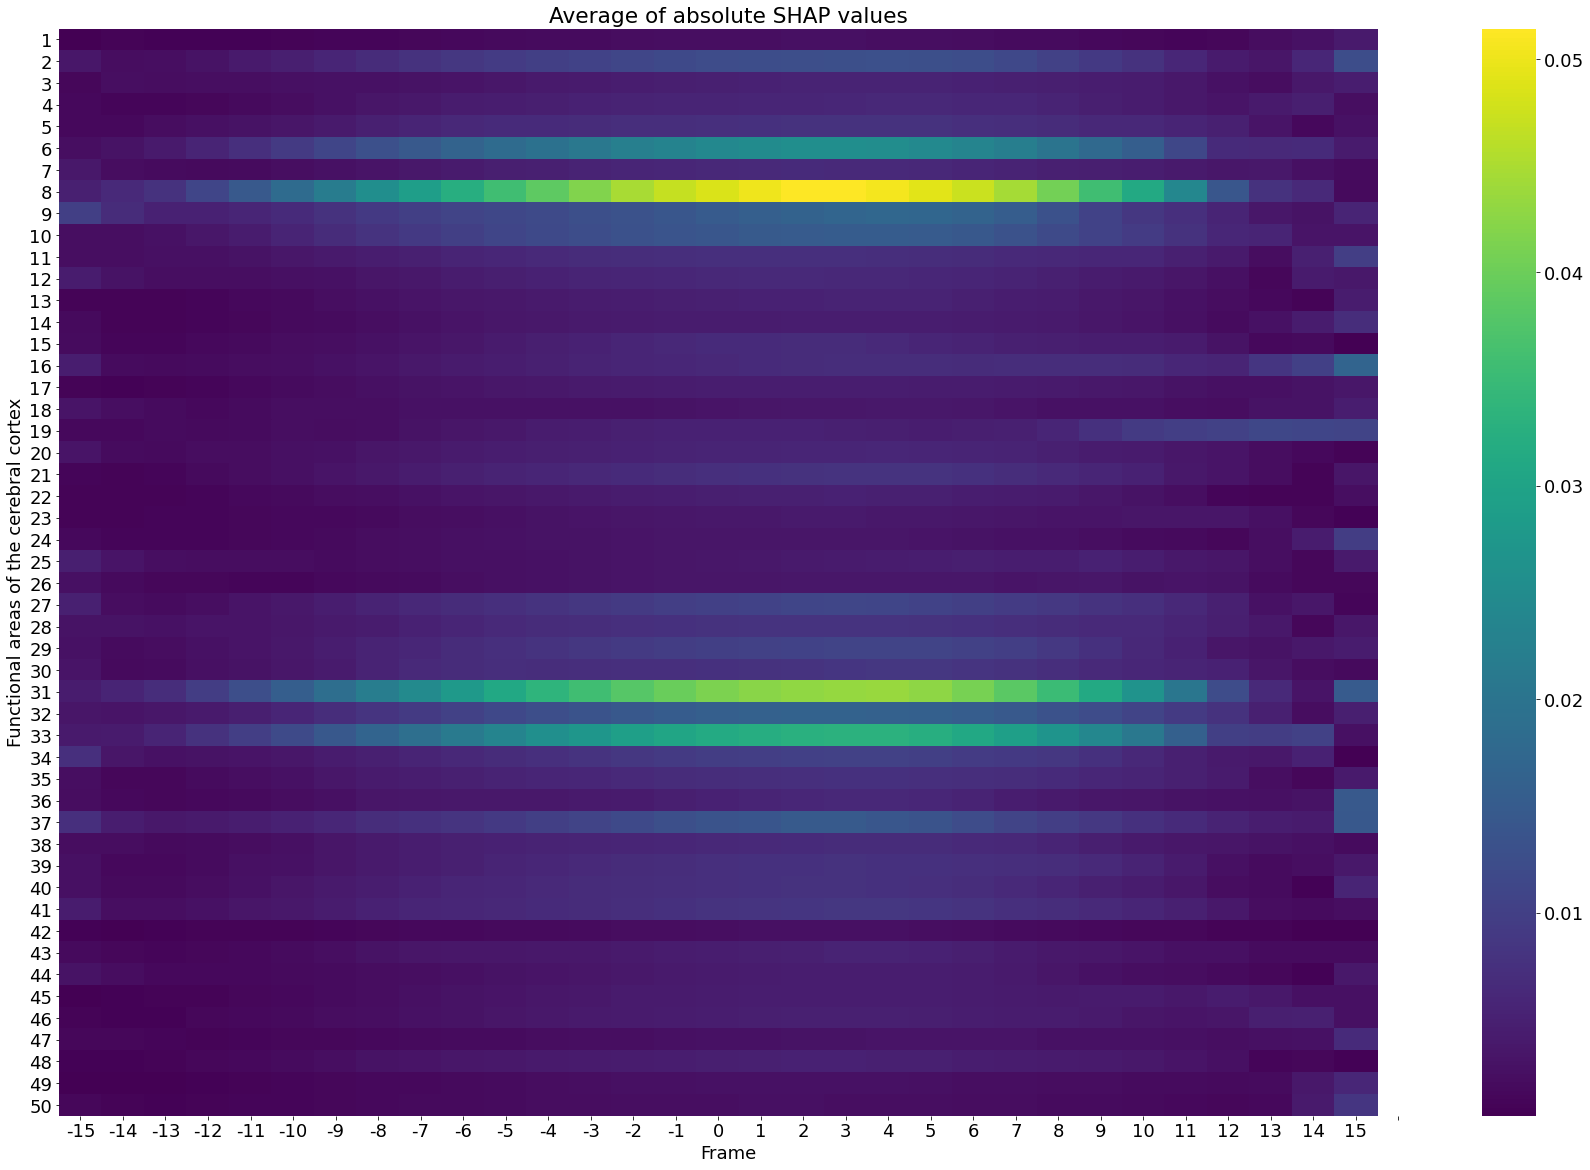

TEST
Mouse 2
The positive proportion is 0.51
The positive proportion is 0.31
The positive proportion is 0.42
The positive proportion is 0.89
The positive proportion is 0.87
The positive proportion is 0.82
The positive proportion is 0.75
The positive proportion is 0.74
The positive proportion is 0.91
The positive proportion is 0.84
The positive proportion is 0.48
The positive proportion is 0.37
0.6401569


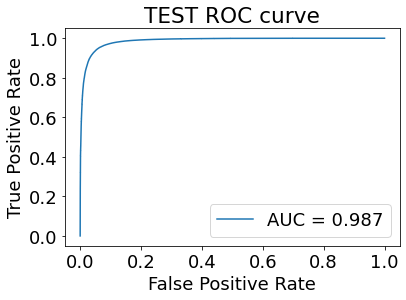

AUC: 0.987
Optimal threshold: 0.551
[ 40380 179070 149965 ...  14548  98346 119449]
(10000,)
Base: 0.6450539827346802



[0.96360756 0.95158291 0.94950136 ... 0.98411821 0.98788818 0.98852561]
[0.9636078  0.9515829  0.94950116 ... 0.98411787 0.9878884  0.9885263 ]


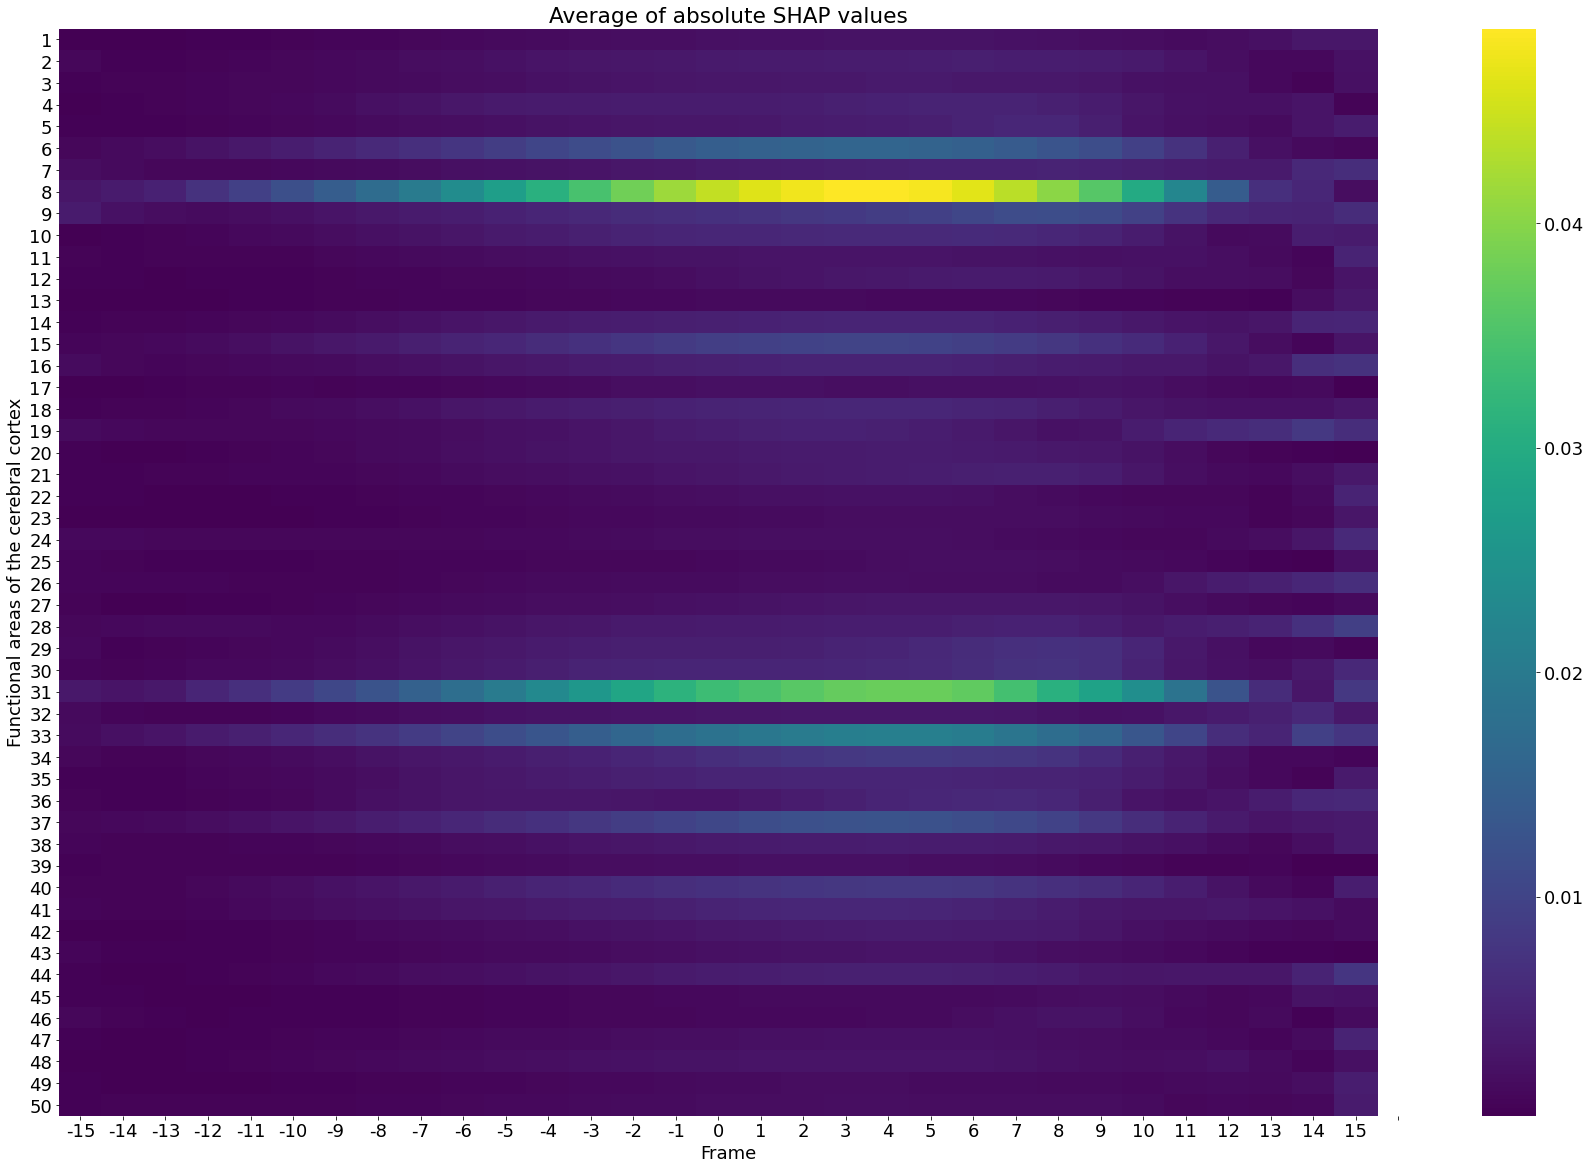

TEST
Mouse 2
The positive proportion is 0.51
The positive proportion is 0.31
The positive proportion is 0.42
The positive proportion is 0.89
The positive proportion is 0.87
The positive proportion is 0.82
The positive proportion is 0.75
The positive proportion is 0.74
The positive proportion is 0.91
The positive proportion is 0.84
The positive proportion is 0.48
The positive proportion is 0.37
0.6201672


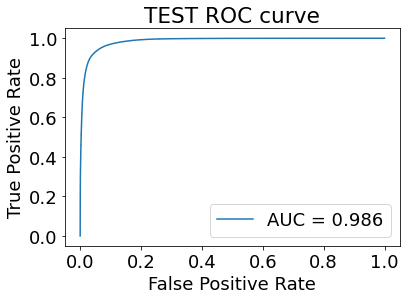

AUC: 0.986
Optimal threshold: 0.439
[ 29798  71198  28480 ...  25418  82799 126784]
(10000,)
Base: 0.6244367361068726



[0.99728751 0.99680937 0.99628055 ... 0.99340149 0.99101695 0.98700947]
[0.99728817 0.99680907 0.9962805  ... 0.99340117 0.99101686 0.9870094 ]


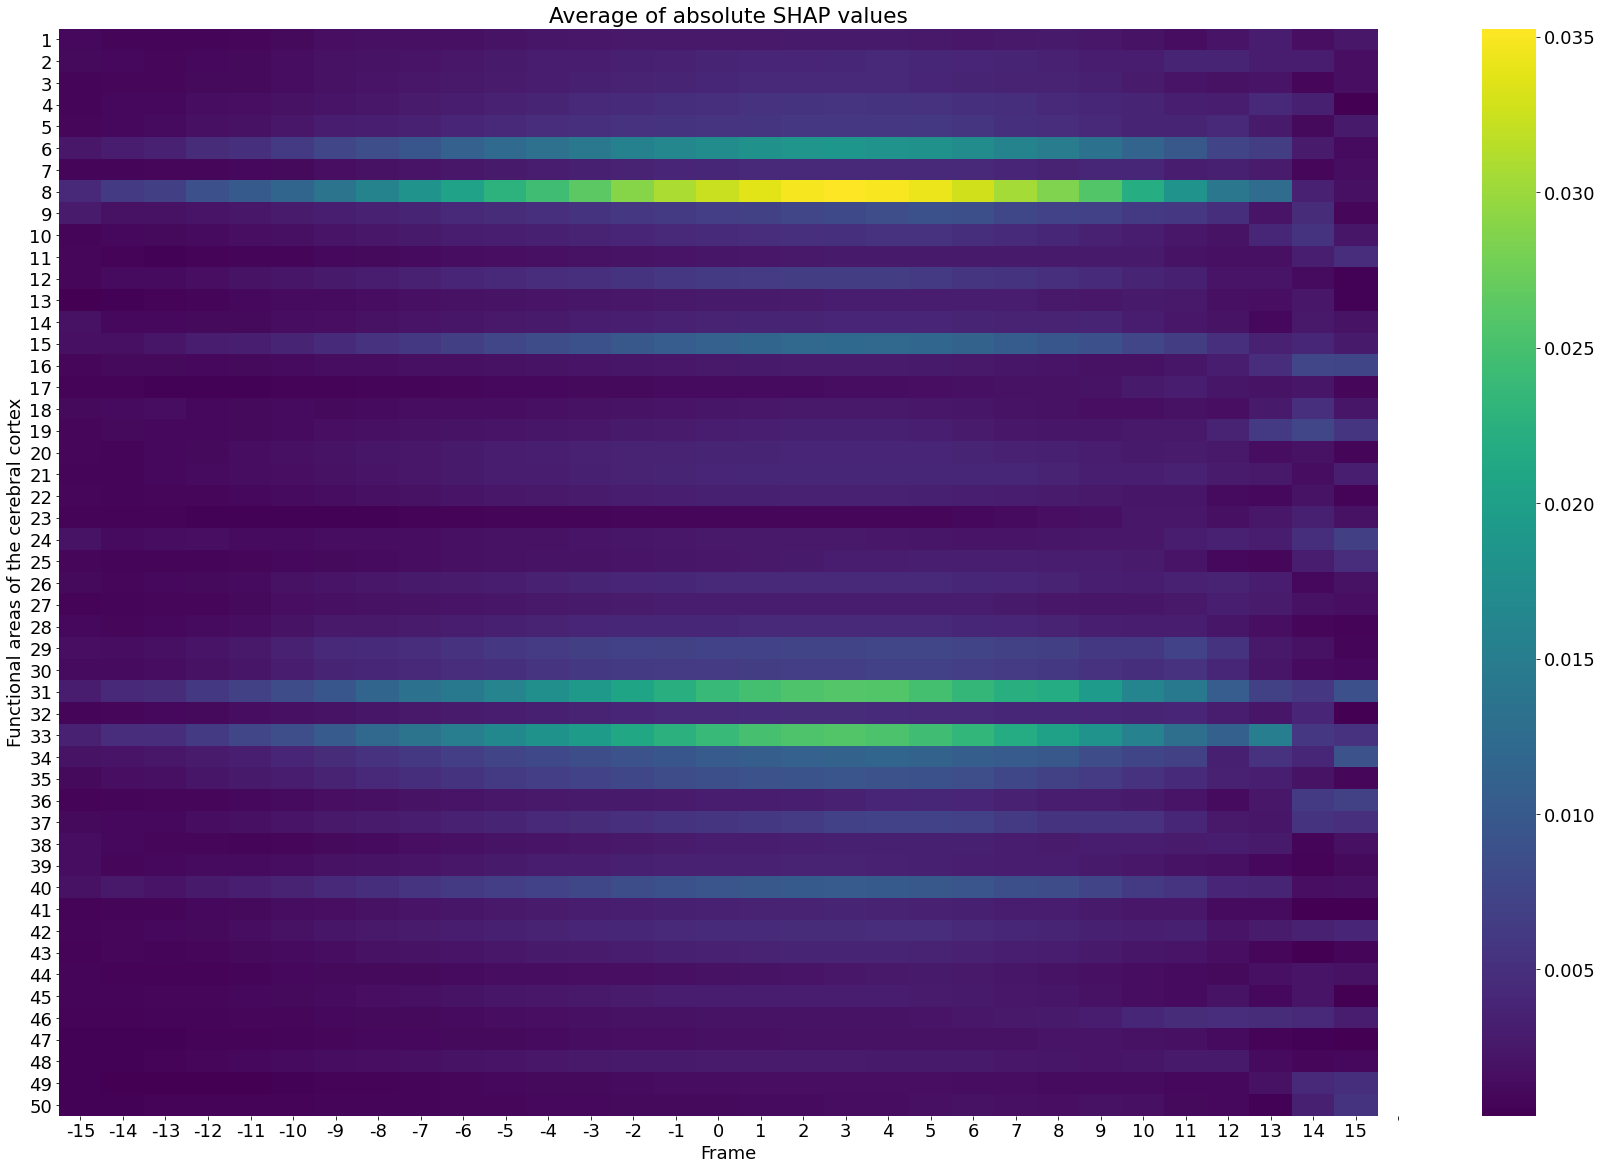

TEST
Mouse 2
The positive proportion is 0.51
The positive proportion is 0.31
The positive proportion is 0.42
The positive proportion is 0.89
The positive proportion is 0.87
The positive proportion is 0.82
The positive proportion is 0.75
The positive proportion is 0.74
The positive proportion is 0.91
The positive proportion is 0.84
The positive proportion is 0.48
The positive proportion is 0.37
0.6018596


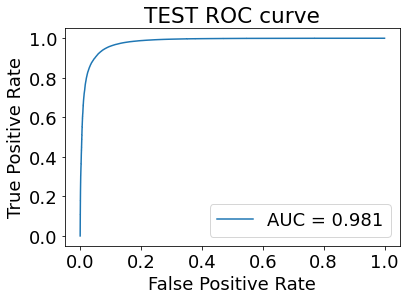

AUC: 0.981
Optimal threshold: 0.363
[183880 176155  14761 ... 197385 202866 140309]
(10000,)
Base: 0.5997981429100037



[0.99549067 0.99354653 0.99550249 ... 0.99152907 0.99073186 0.98783565]
[0.99549043 0.9935465  0.9955028  ... 0.9915291  0.9907317  0.98783624]


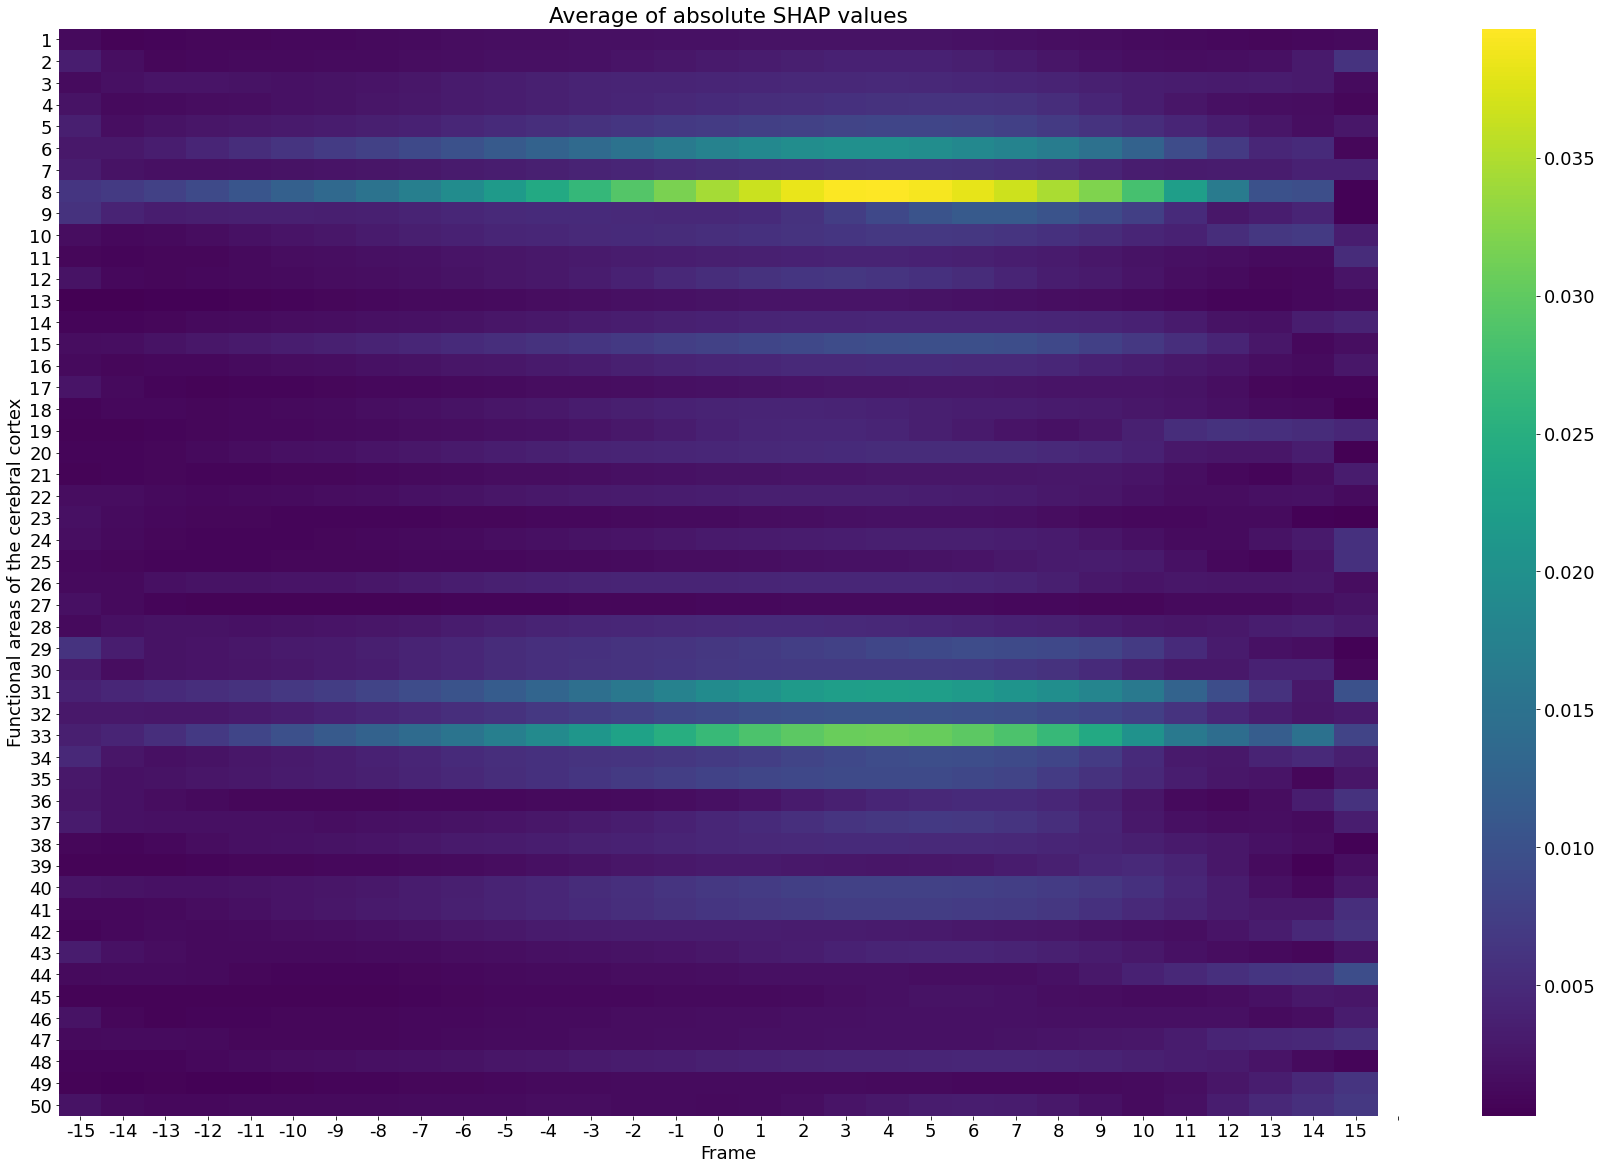

TEST
Mouse 2
The positive proportion is 0.51
The positive proportion is 0.31
The positive proportion is 0.42
The positive proportion is 0.89
The positive proportion is 0.87
The positive proportion is 0.82
The positive proportion is 0.75
The positive proportion is 0.74
The positive proportion is 0.91
The positive proportion is 0.84
The positive proportion is 0.48
The positive proportion is 0.37
0.61883384


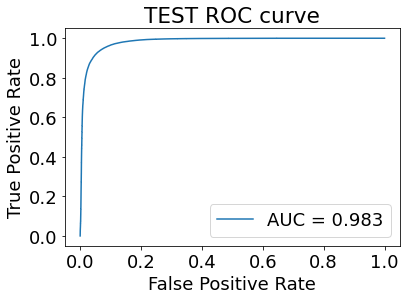

AUC: 0.983
Optimal threshold: 0.435
[ 79777 178624 195730 ...  43141  91124  98849]
(10000,)
Base: 0.6225868463516235



[0.99582572 0.99427847 0.993973   ... 0.99292518 0.99093242 0.98948904]
[0.9958258  0.99427855 0.99397314 ... 0.99292505 0.9909322  0.98948896]


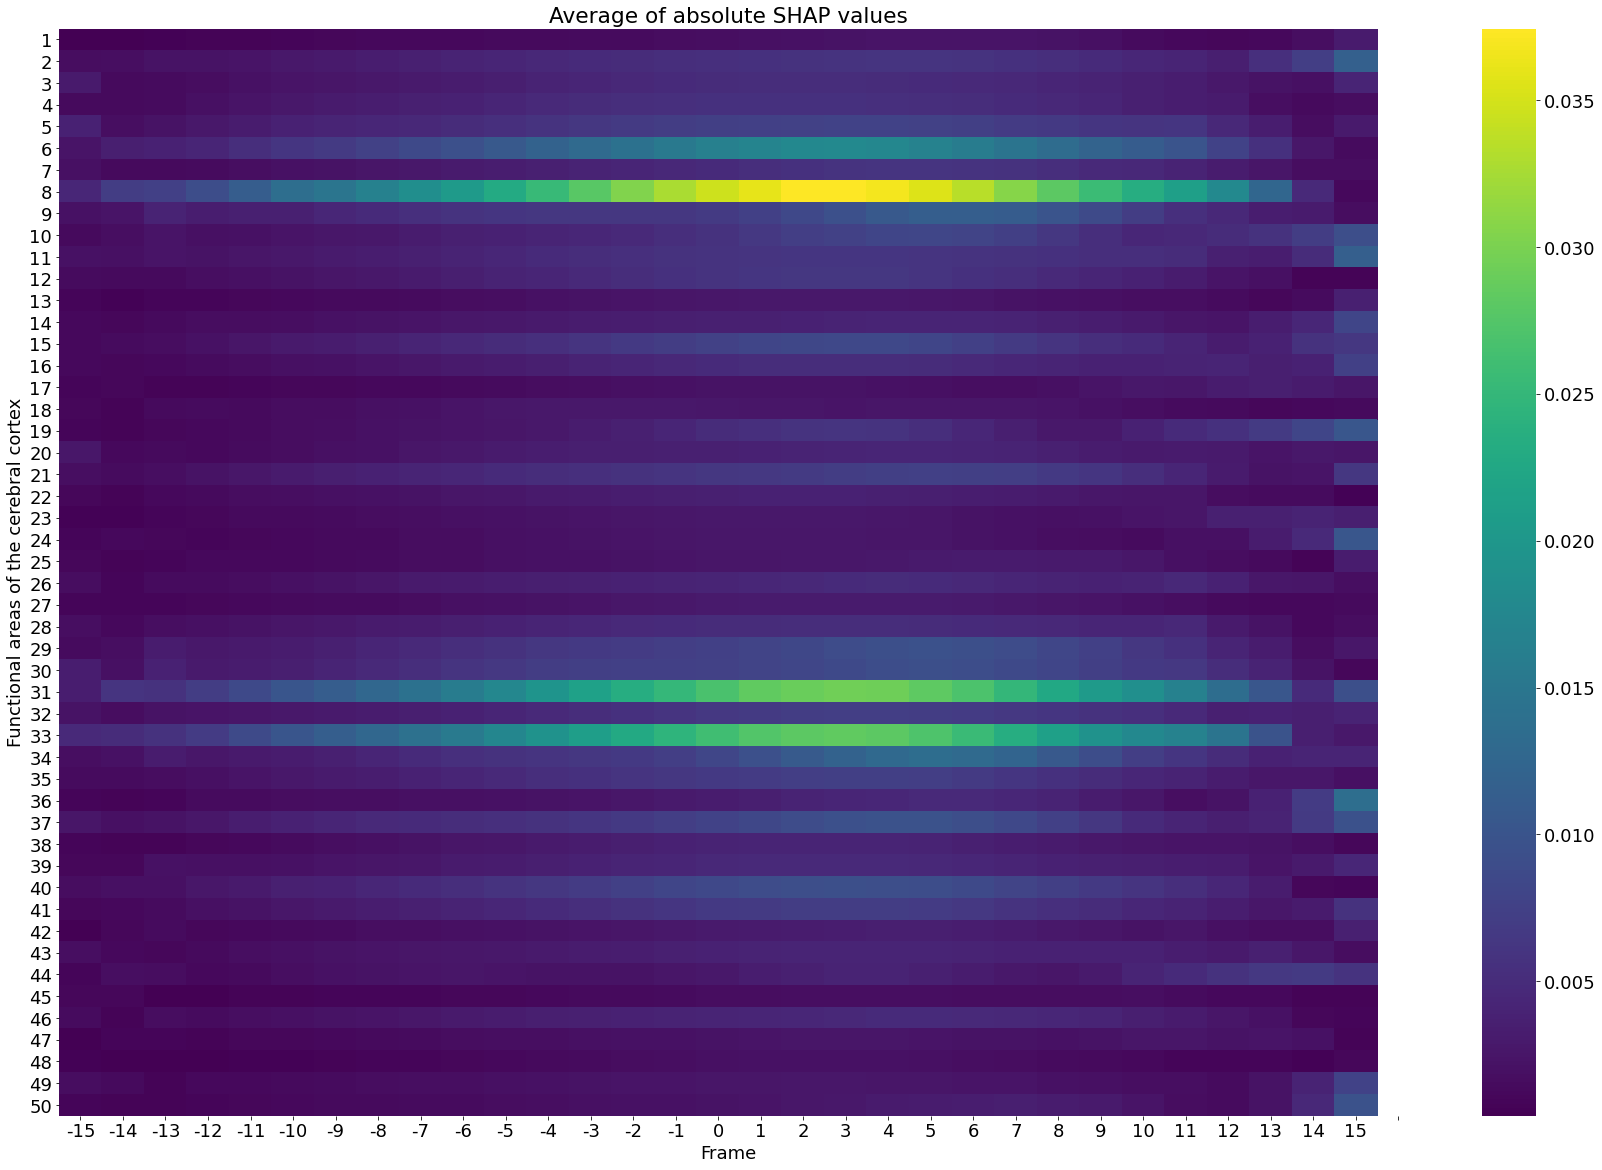

TEST
Mouse 3
The positive proportion is 0.79
The positive proportion is 0.87
The positive proportion is 0.83
The positive proportion is 0.81
The positive proportion is 0.84
The positive proportion is 0.67
The positive proportion is 0.67
The positive proportion is 0.61
The positive proportion is 0.43
The positive proportion is 0.65
The positive proportion is 0.52
The positive proportion is 0.45
The positive proportion is 0.49
The positive proportion is 0.44
0.65762496


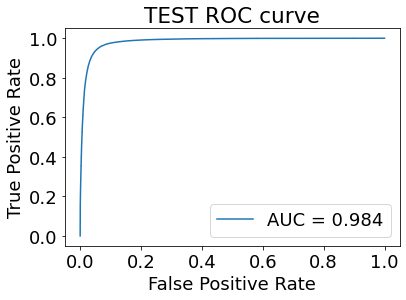

AUC: 0.984
Optimal threshold: 0.661
[  5290 111820 143957 ... 221506 106284  46170]
(10000,)
Base: 0.6554338335990906



[0.99595293 0.99371284 0.98954589 ... 0.99893618 0.99879311 0.99873519]
[0.9959531  0.99371284 0.9895458  ... 0.99893534 0.99879324 0.99873316]


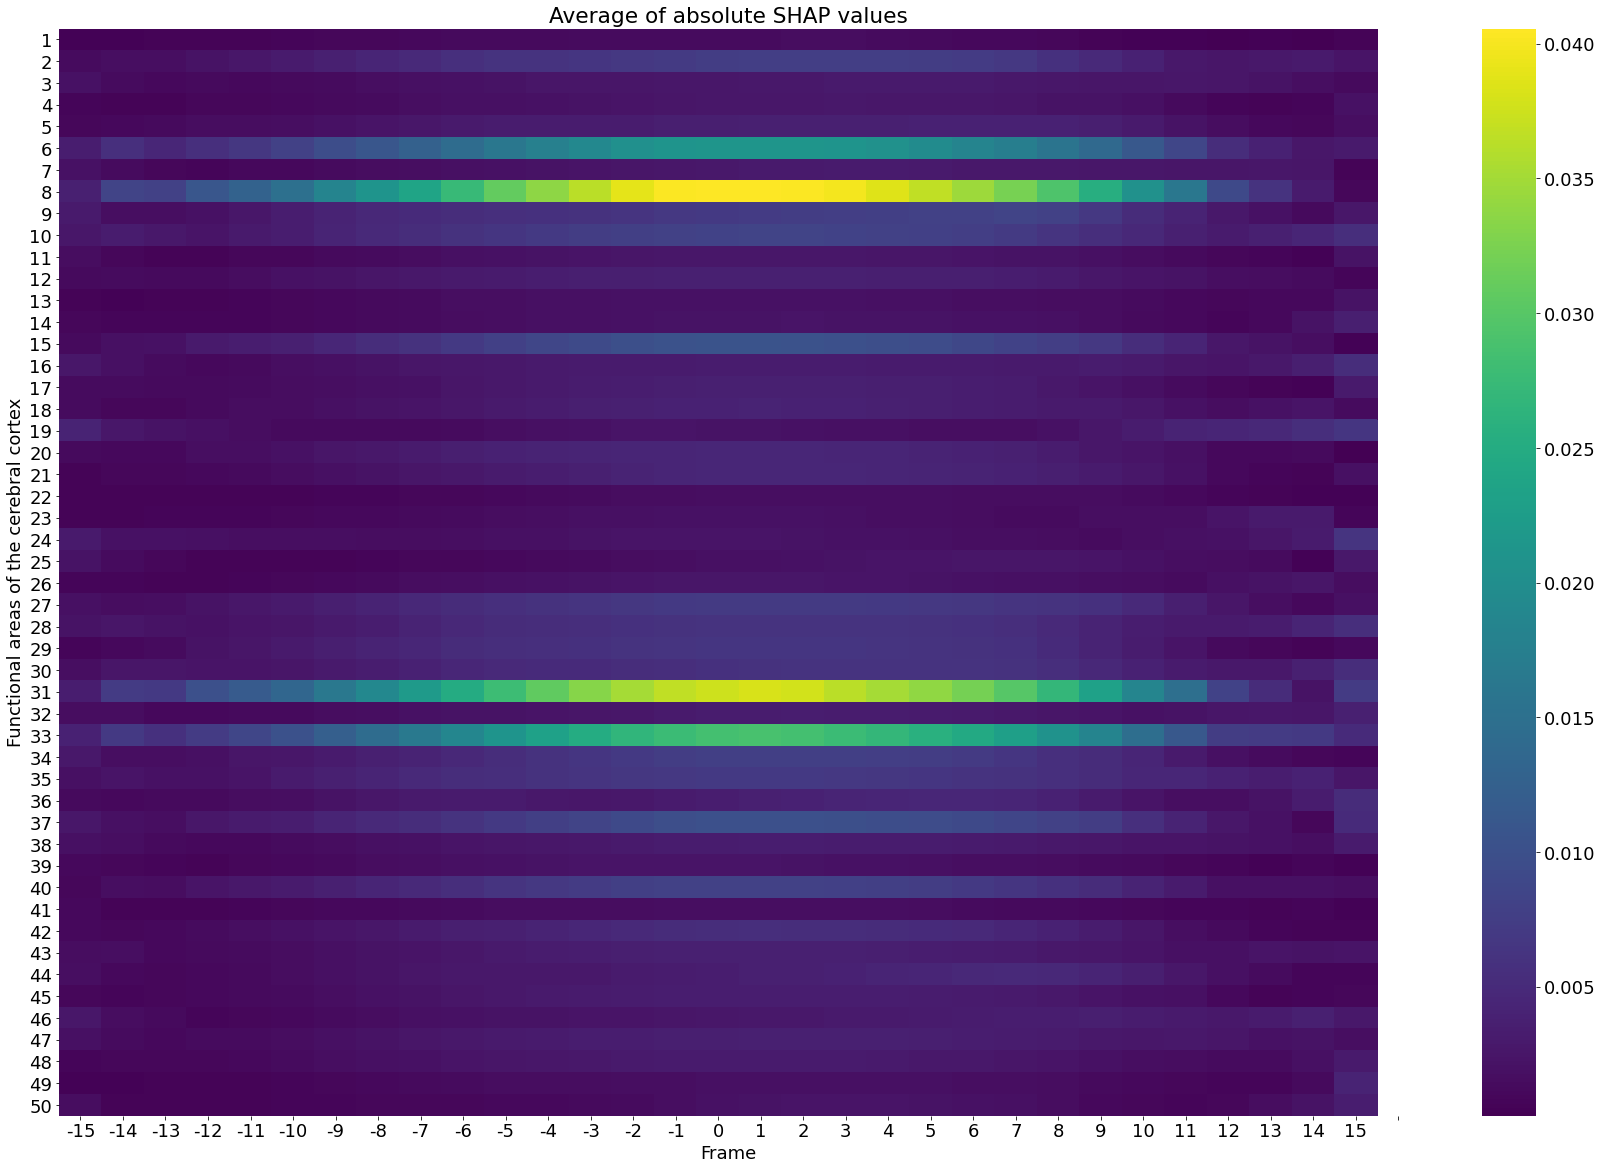

TEST
Mouse 3
The positive proportion is 0.79
The positive proportion is 0.87
The positive proportion is 0.83
The positive proportion is 0.81
The positive proportion is 0.84
The positive proportion is 0.67
The positive proportion is 0.67
The positive proportion is 0.61
The positive proportion is 0.43
The positive proportion is 0.65
The positive proportion is 0.52
The positive proportion is 0.45
The positive proportion is 0.49
The positive proportion is 0.44
0.66208225


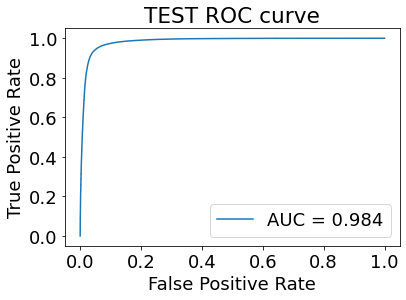

AUC: 0.984
Optimal threshold: 0.774
[  2168 228314 111563 ... 222195  24680 151473]
(10000,)
Base: 0.6591573357582092



[0.98156138 0.98061209 0.9823686  ... 0.81796925 0.89966945 0.90297192]
[0.98156136 0.980612   0.98236877 ... 0.81796503 0.8996674  0.902972  ]


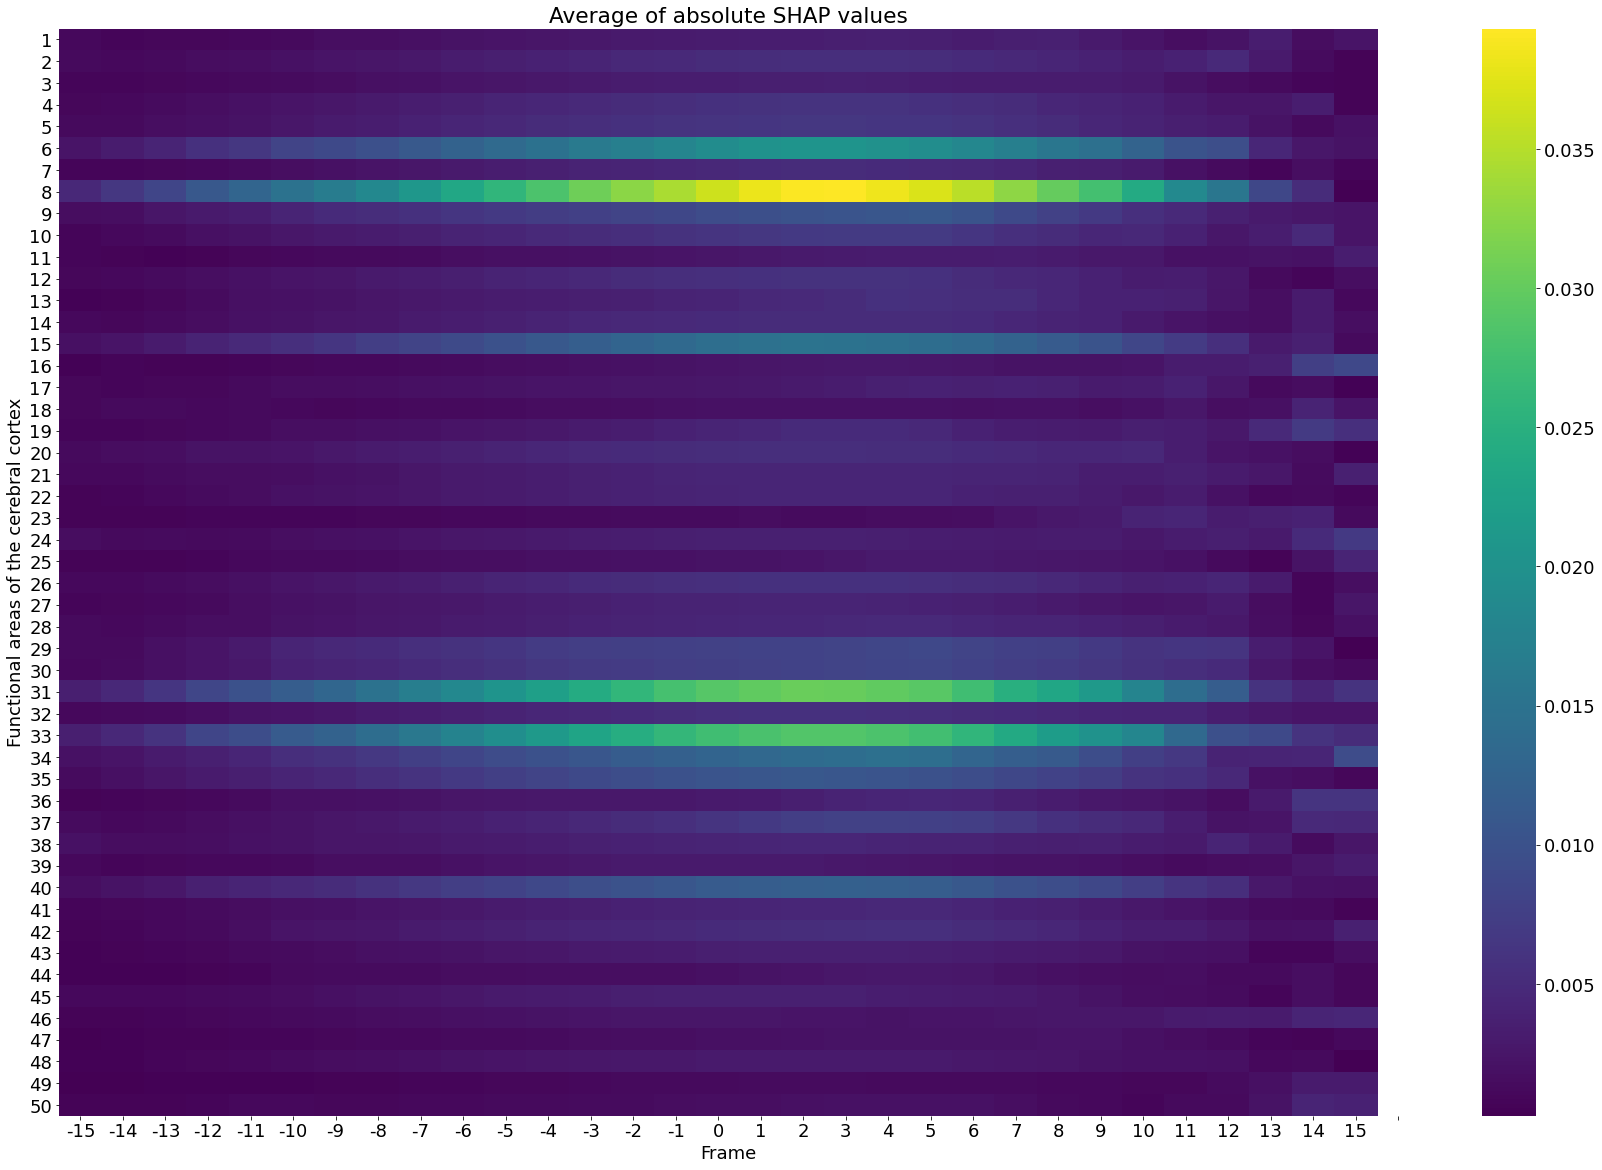

TEST
Mouse 3
The positive proportion is 0.79
The positive proportion is 0.87
The positive proportion is 0.83
The positive proportion is 0.81
The positive proportion is 0.84
The positive proportion is 0.67
The positive proportion is 0.67
The positive proportion is 0.61
The positive proportion is 0.43
The positive proportion is 0.65
The positive proportion is 0.52
The positive proportion is 0.45
The positive proportion is 0.49
The positive proportion is 0.44
0.657348


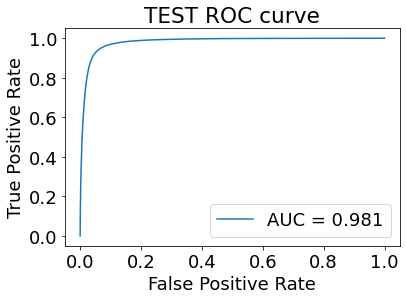

AUC: 0.981
Optimal threshold: 0.720
[ 89234 204355 251552 ... 137679 127989  15725]
(10000,)
Base: 0.6528408527374268



[0.99789714 0.99759543 0.99715985 ... 0.99839534 0.99915958 0.9994713 ]
[0.9978968 0.9975959 0.9971599 ... 0.9983938 0.9991597 0.9994725]


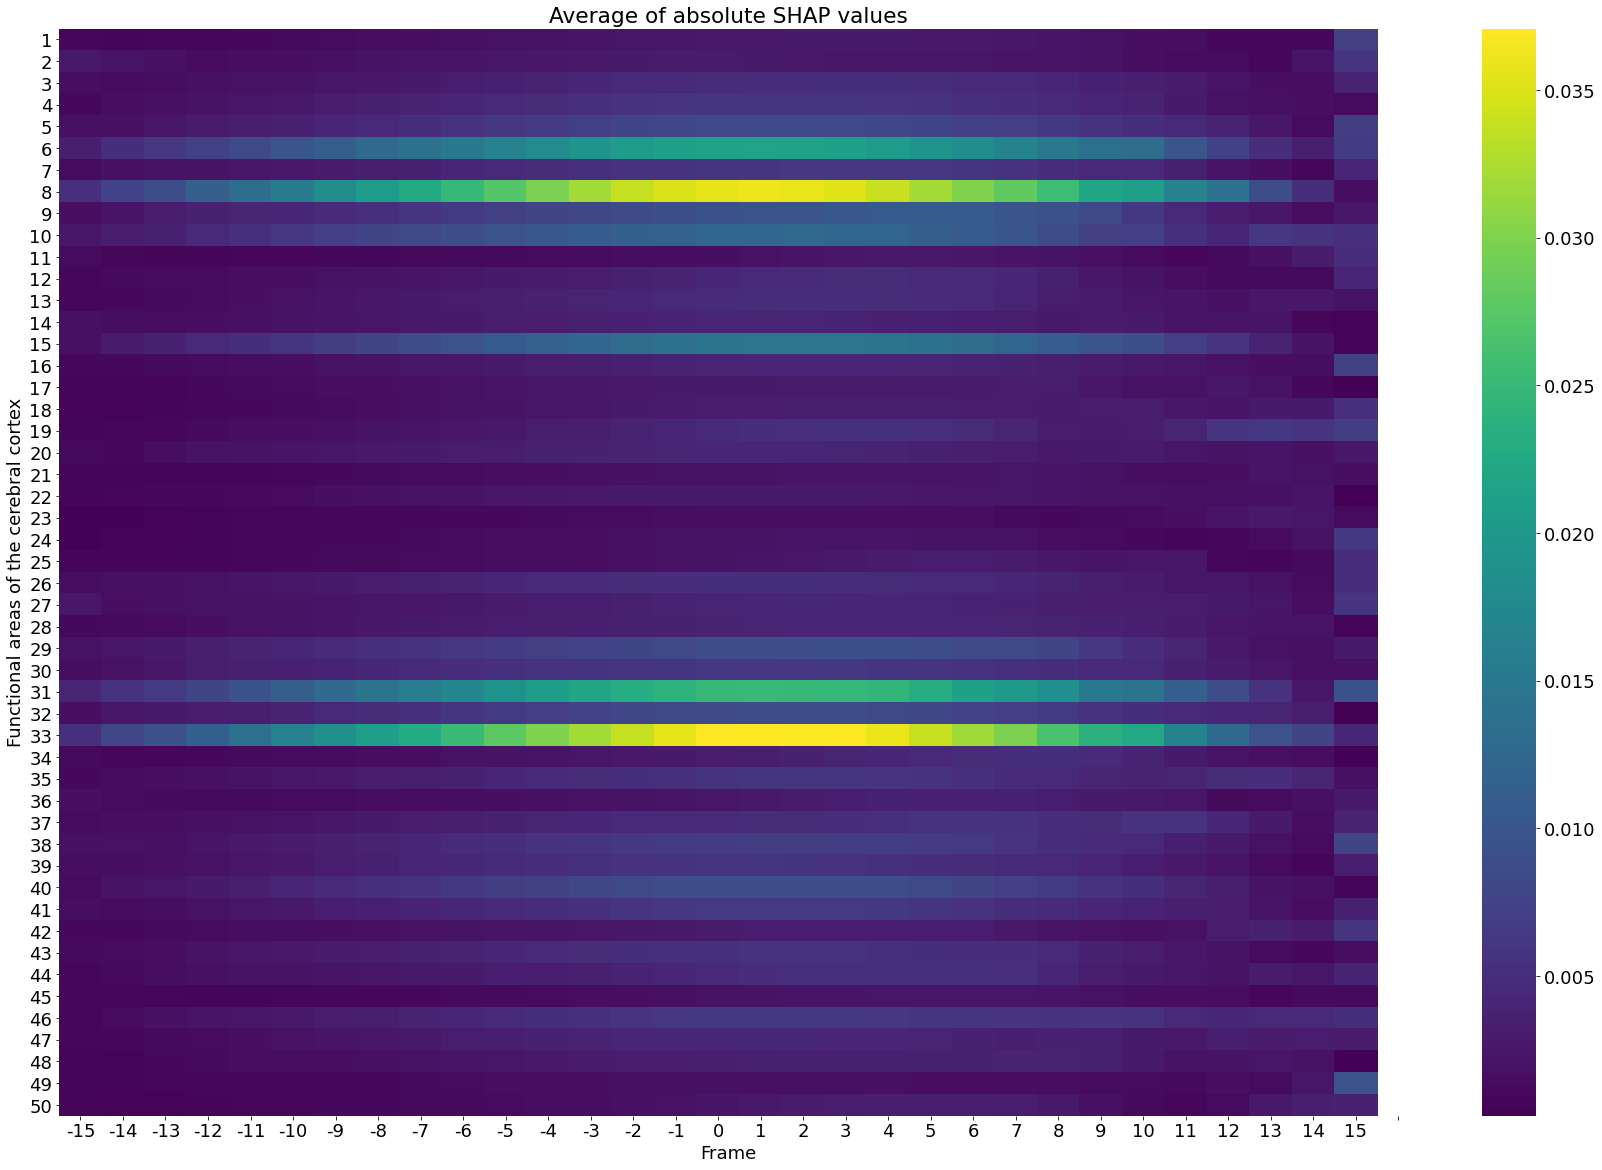

TEST
Mouse 3
The positive proportion is 0.79
The positive proportion is 0.87
The positive proportion is 0.83
The positive proportion is 0.81
The positive proportion is 0.84
The positive proportion is 0.67
The positive proportion is 0.67
The positive proportion is 0.61
The positive proportion is 0.43
The positive proportion is 0.65
The positive proportion is 0.52
The positive proportion is 0.45
The positive proportion is 0.49
The positive proportion is 0.44
0.66174066


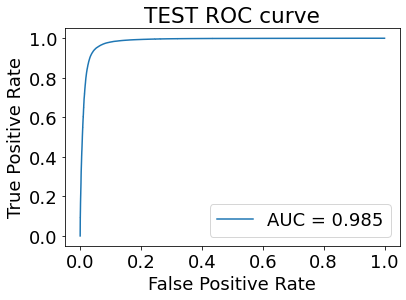

AUC: 0.985
Optimal threshold: 0.783
[127007 114302 179035 ...  86417 144085  47616]
(10000,)
Base: 0.6565750241279602



[0.99269133 0.99347432 0.99332924 ... 0.99090859 0.99460458 0.99210711]
[0.9926914  0.9934741  0.99332917 ... 0.99090946 0.9946042  0.9921093 ]


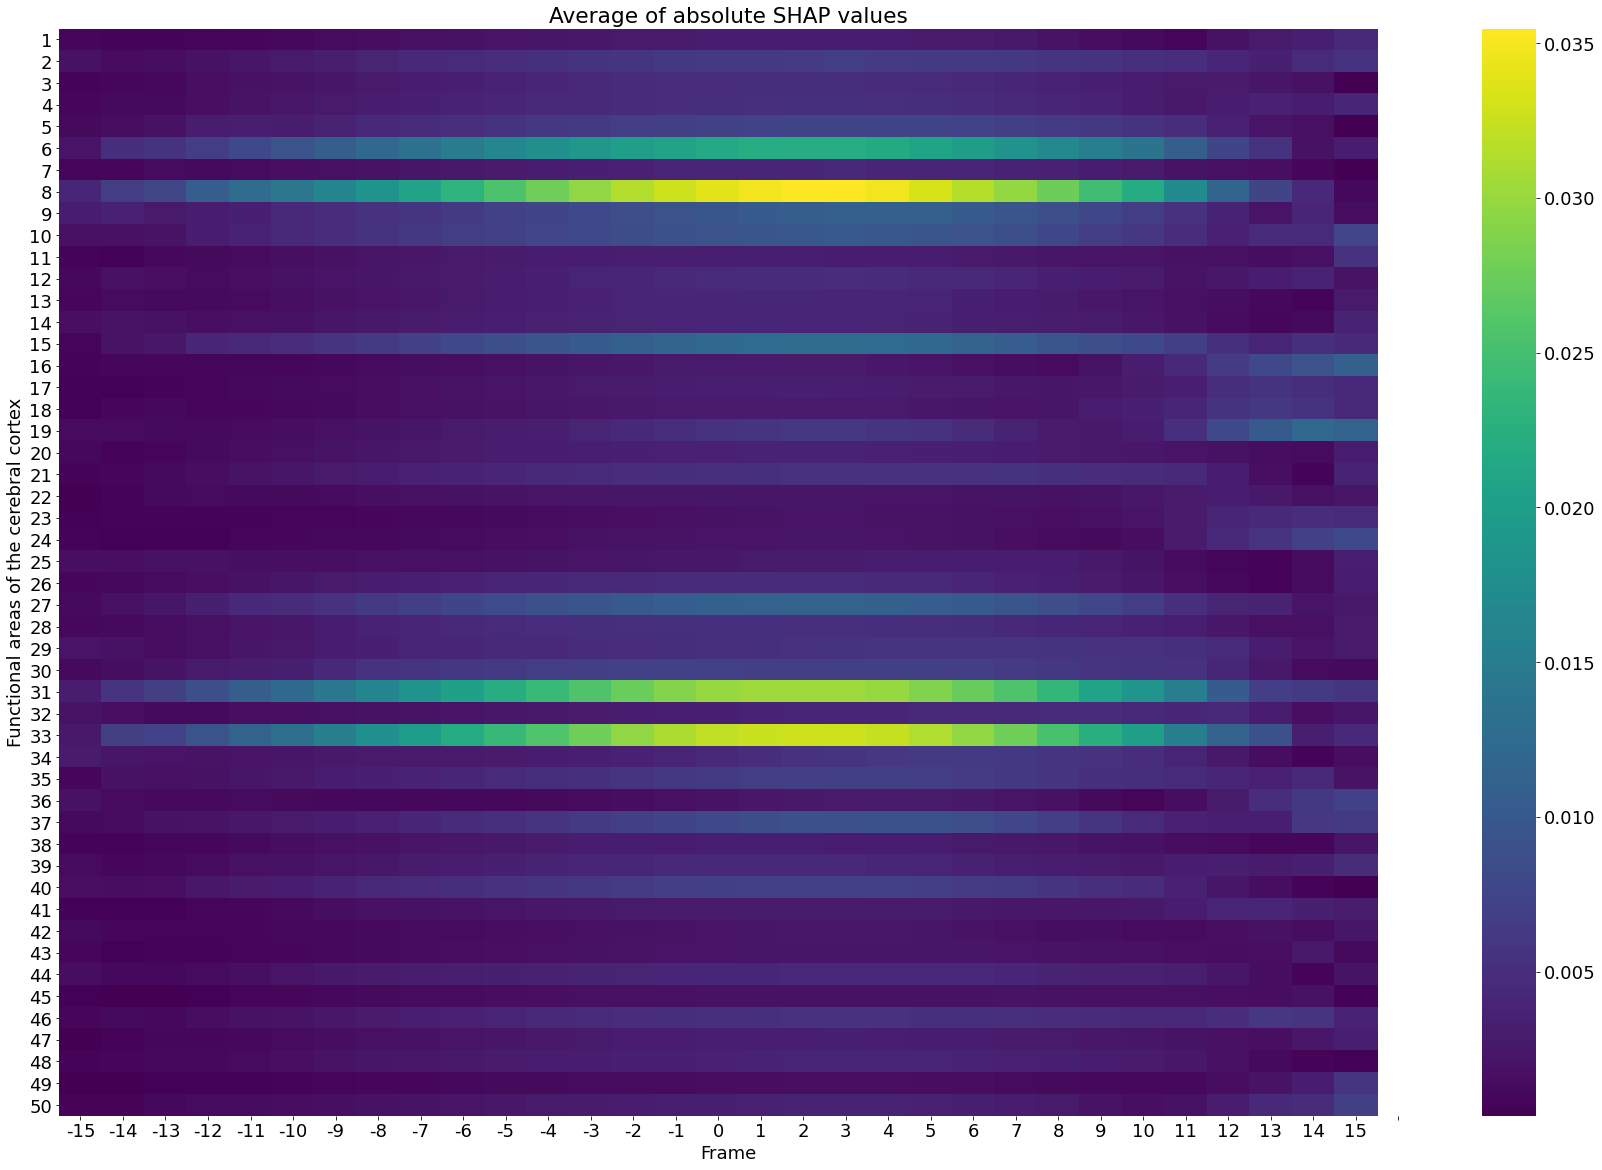

TEST
Mouse 4
The positive proportion is 0.36
The positive proportion is 0.41
The positive proportion is 0.65
The positive proportion is 0.60
The positive proportion is 0.56
The positive proportion is 0.60
The positive proportion is 0.47
The positive proportion is 0.75
The positive proportion is 0.59
The positive proportion is 0.49
The positive proportion is 0.65
The positive proportion is 0.69
The positive proportion is 0.63
The positive proportion is 0.67
The positive proportion is 0.63
0.60009843


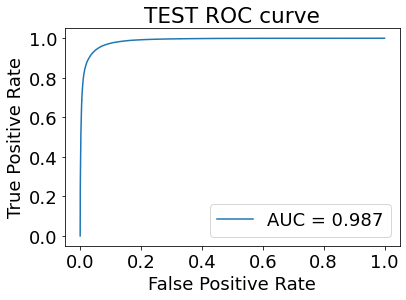

AUC: 0.987
Optimal threshold: 0.742
[ 60880  67766  79851 ...  71959 135415  59155]
(10000,)
Base: 0.6038134694099426



[0.99324697 0.99140307 0.98820306 ... 0.33083377 0.57243208 0.873358  ]
[0.99324685 0.99140346 0.9882031  ... 0.33083344 0.5724318  0.87335783]


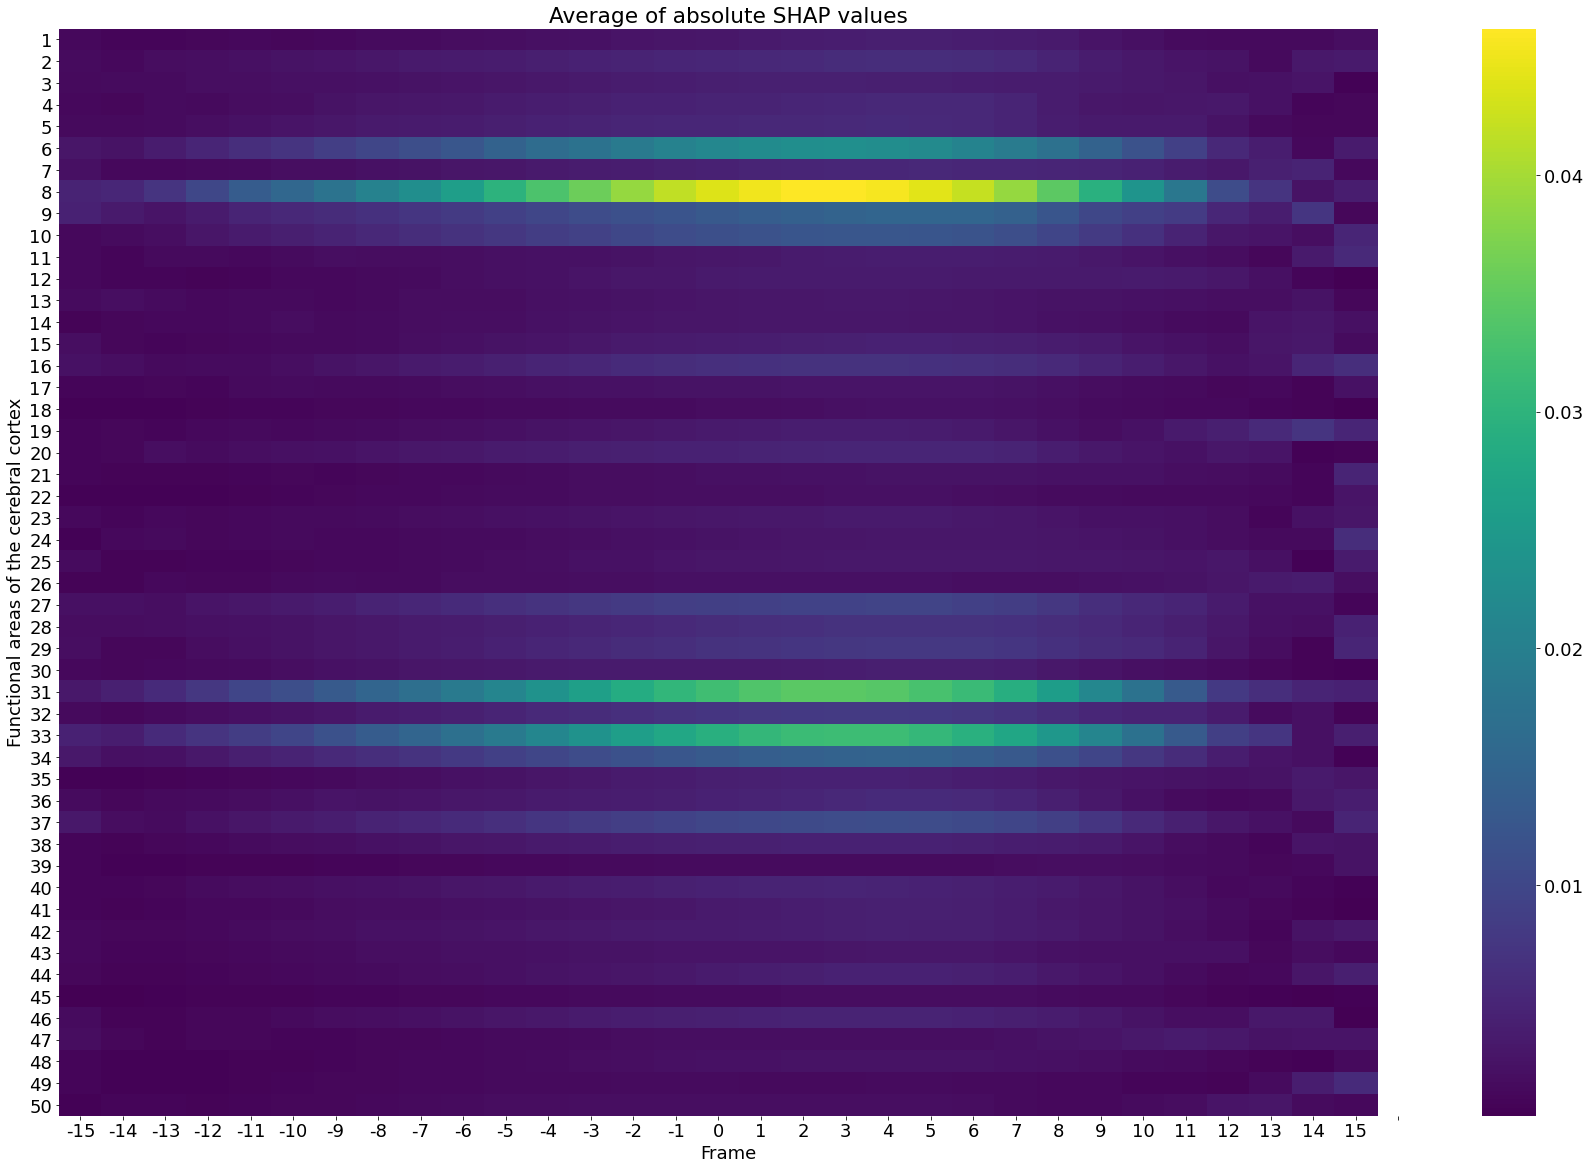

TEST
Mouse 4
The positive proportion is 0.36
The positive proportion is 0.41
The positive proportion is 0.65
The positive proportion is 0.60
The positive proportion is 0.56
The positive proportion is 0.60
The positive proportion is 0.47
The positive proportion is 0.75
The positive proportion is 0.59
The positive proportion is 0.49
The positive proportion is 0.65
The positive proportion is 0.69
The positive proportion is 0.63
The positive proportion is 0.67
The positive proportion is 0.63
0.6046609


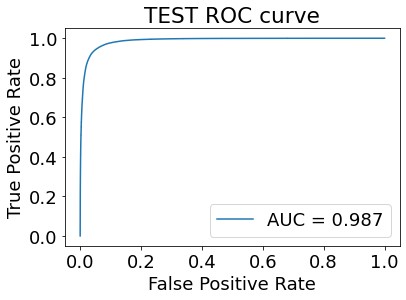

AUC: 0.987
Optimal threshold: 0.774
[205935  65277 117540 ... 144229  75530 258532]
(10000,)
Base: 0.6063448190689087



[0.99733586 0.99763114 0.99765906 ... 0.66213995 0.7653341  0.87524149]
[0.997336   0.99763143 0.9976592  ... 0.66213894 0.76533395 0.87524086]


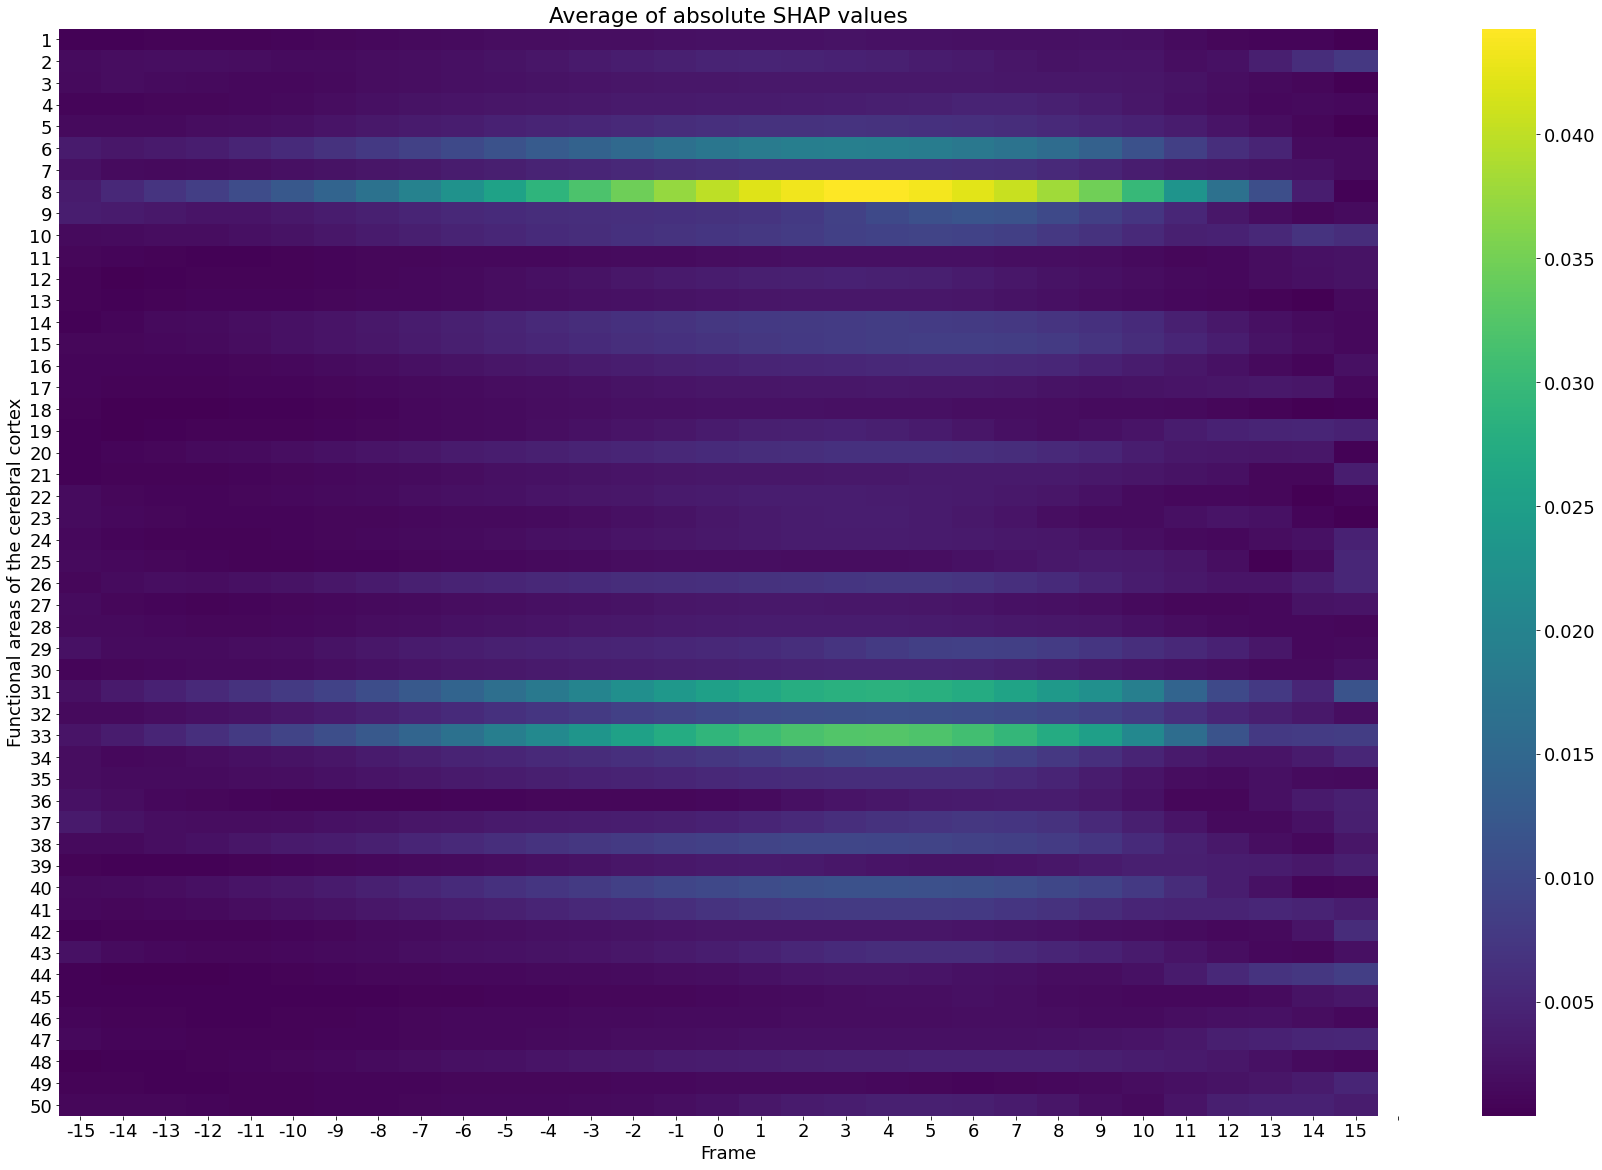

TEST
Mouse 4
The positive proportion is 0.36
The positive proportion is 0.41
The positive proportion is 0.65
The positive proportion is 0.60
The positive proportion is 0.56
The positive proportion is 0.60
The positive proportion is 0.47
The positive proportion is 0.75
The positive proportion is 0.59
The positive proportion is 0.49
The positive proportion is 0.65
The positive proportion is 0.69
The positive proportion is 0.63
The positive proportion is 0.67
The positive proportion is 0.63
0.58586675


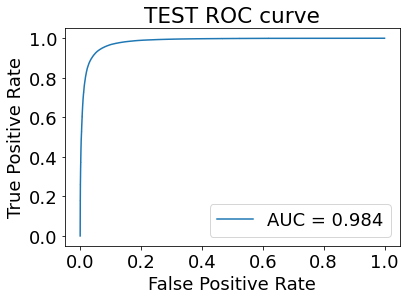

AUC: 0.984
Optimal threshold: 0.637
[106958 175496 157805 ... 253180  20480 255996]
(10000,)
Base: 0.5848844051361084



[0.99690027 0.9977678  0.99813568 ... 0.68491473 0.77034576 0.83388525]
[0.99690056 0.99776804 0.9981354  ... 0.6849135  0.77034533 0.83388567]


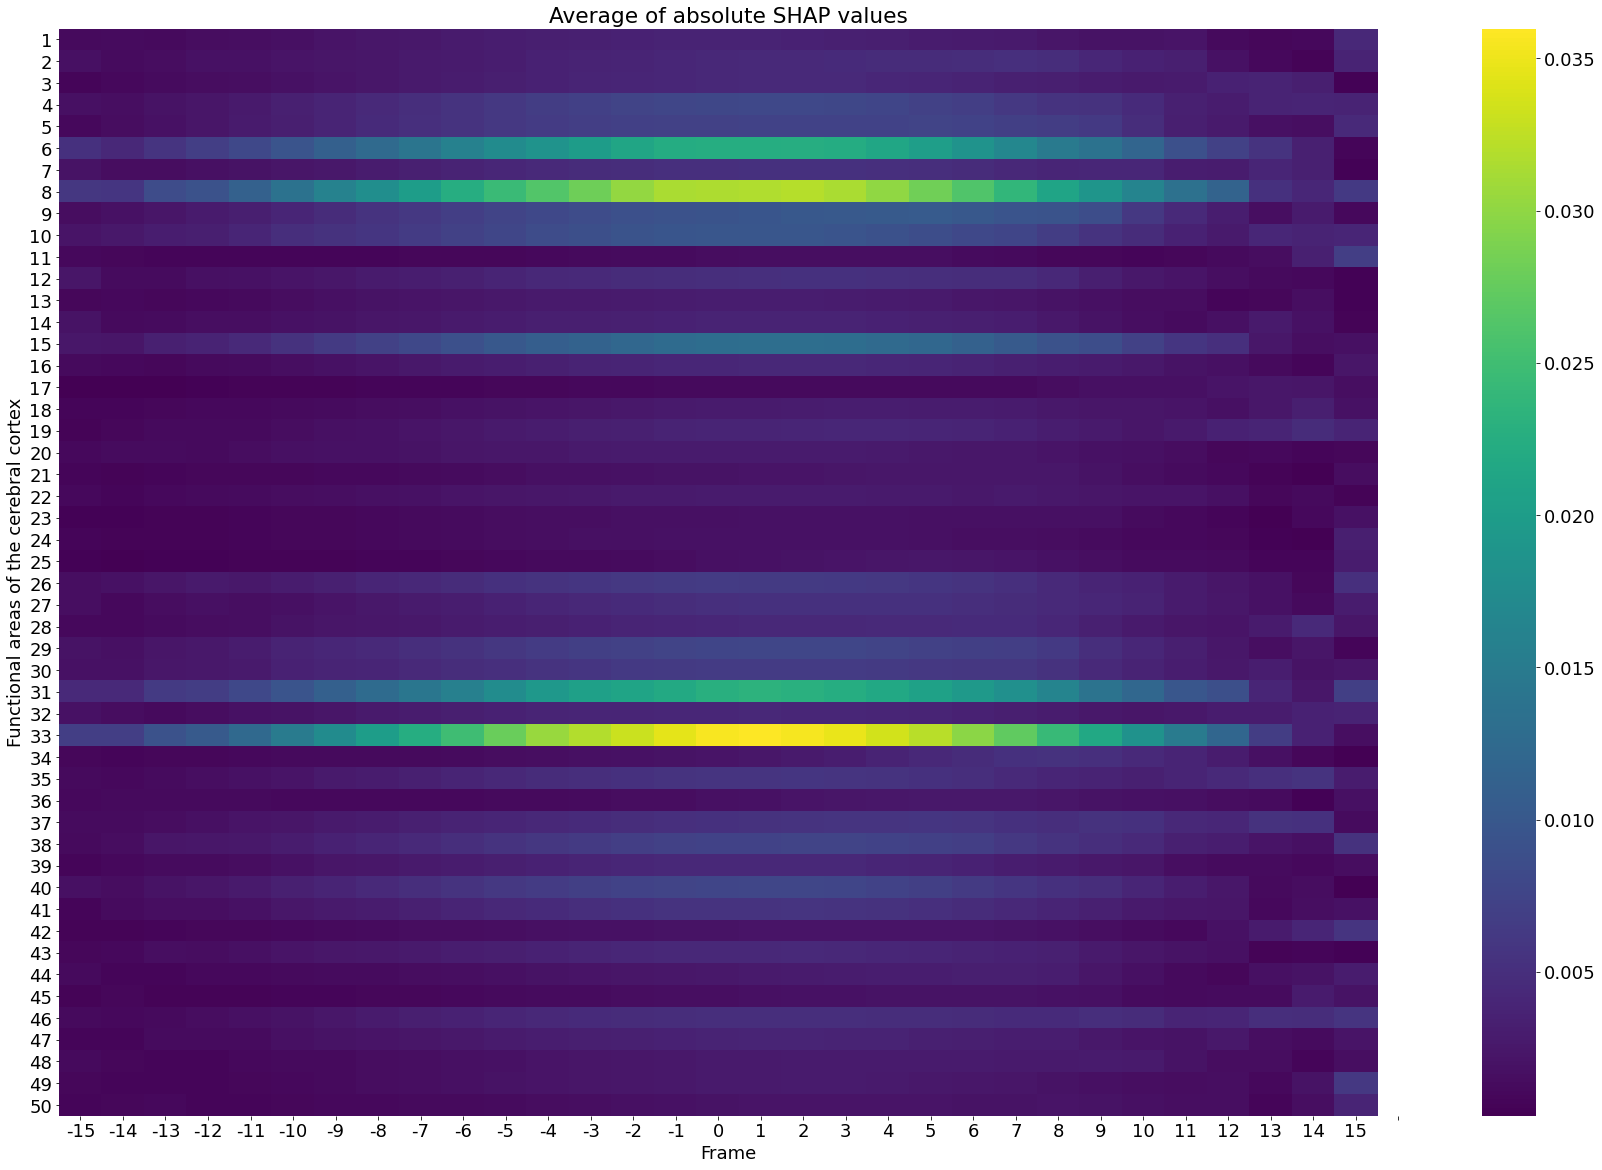

TEST
Mouse 4
The positive proportion is 0.36
The positive proportion is 0.41
The positive proportion is 0.65
The positive proportion is 0.60
The positive proportion is 0.56
The positive proportion is 0.60
The positive proportion is 0.47
The positive proportion is 0.75
The positive proportion is 0.59
The positive proportion is 0.49
The positive proportion is 0.65
The positive proportion is 0.69
The positive proportion is 0.63
The positive proportion is 0.67
The positive proportion is 0.63
0.57702386


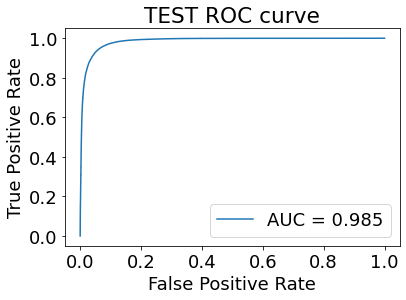

AUC: 0.985
Optimal threshold: 0.521
[196609  82673  43663 ... 224326  23963  83146]
(10000,)
Base: 0.579164445400238



[0.99743896 0.99734427 0.9975991  ... 0.47461026 0.66375392 0.86283486]
[0.9974388  0.99734426 0.997599   ... 0.47461024 0.663754   0.86283535]


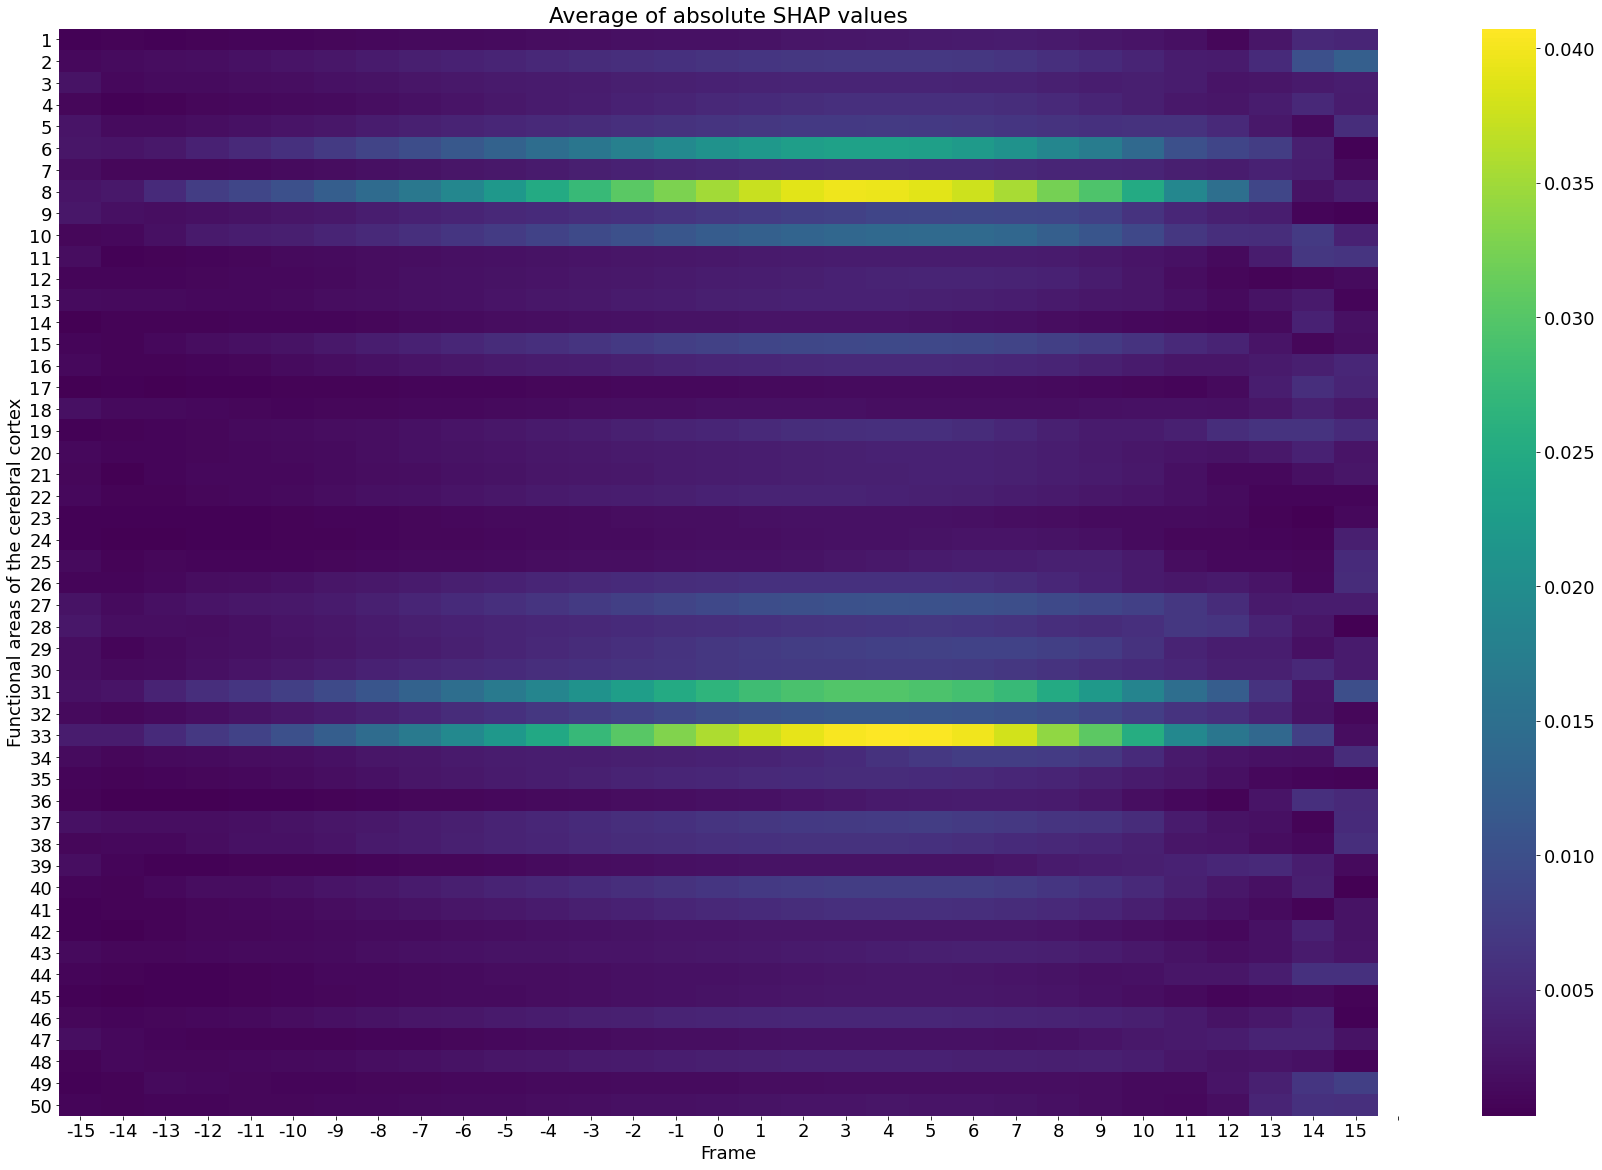

TEST
Mouse 5
The positive proportion is 0.94
The positive proportion is 0.95
The positive proportion is 0.83
The positive proportion is 0.77
The positive proportion is 0.78
The positive proportion is 0.75
The positive proportion is 0.80
The positive proportion is 0.78
The positive proportion is 0.85
The positive proportion is 0.72
The positive proportion is 0.82
The positive proportion is 0.64
0.8414867


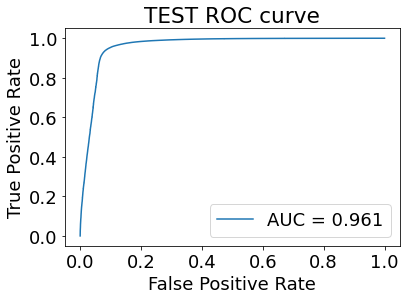

AUC: 0.961
Optimal threshold: 0.923
[ 79071  50346  57560 ... 131892 186581  40297]
(10000,)
Base: 0.8448832035064697



[0.92380506 0.95061652 0.95903254 ... 0.09446662 0.08067989 0.06939103]
[0.9238051  0.9506165  0.9590327  ... 0.09446636 0.08068025 0.06939164]


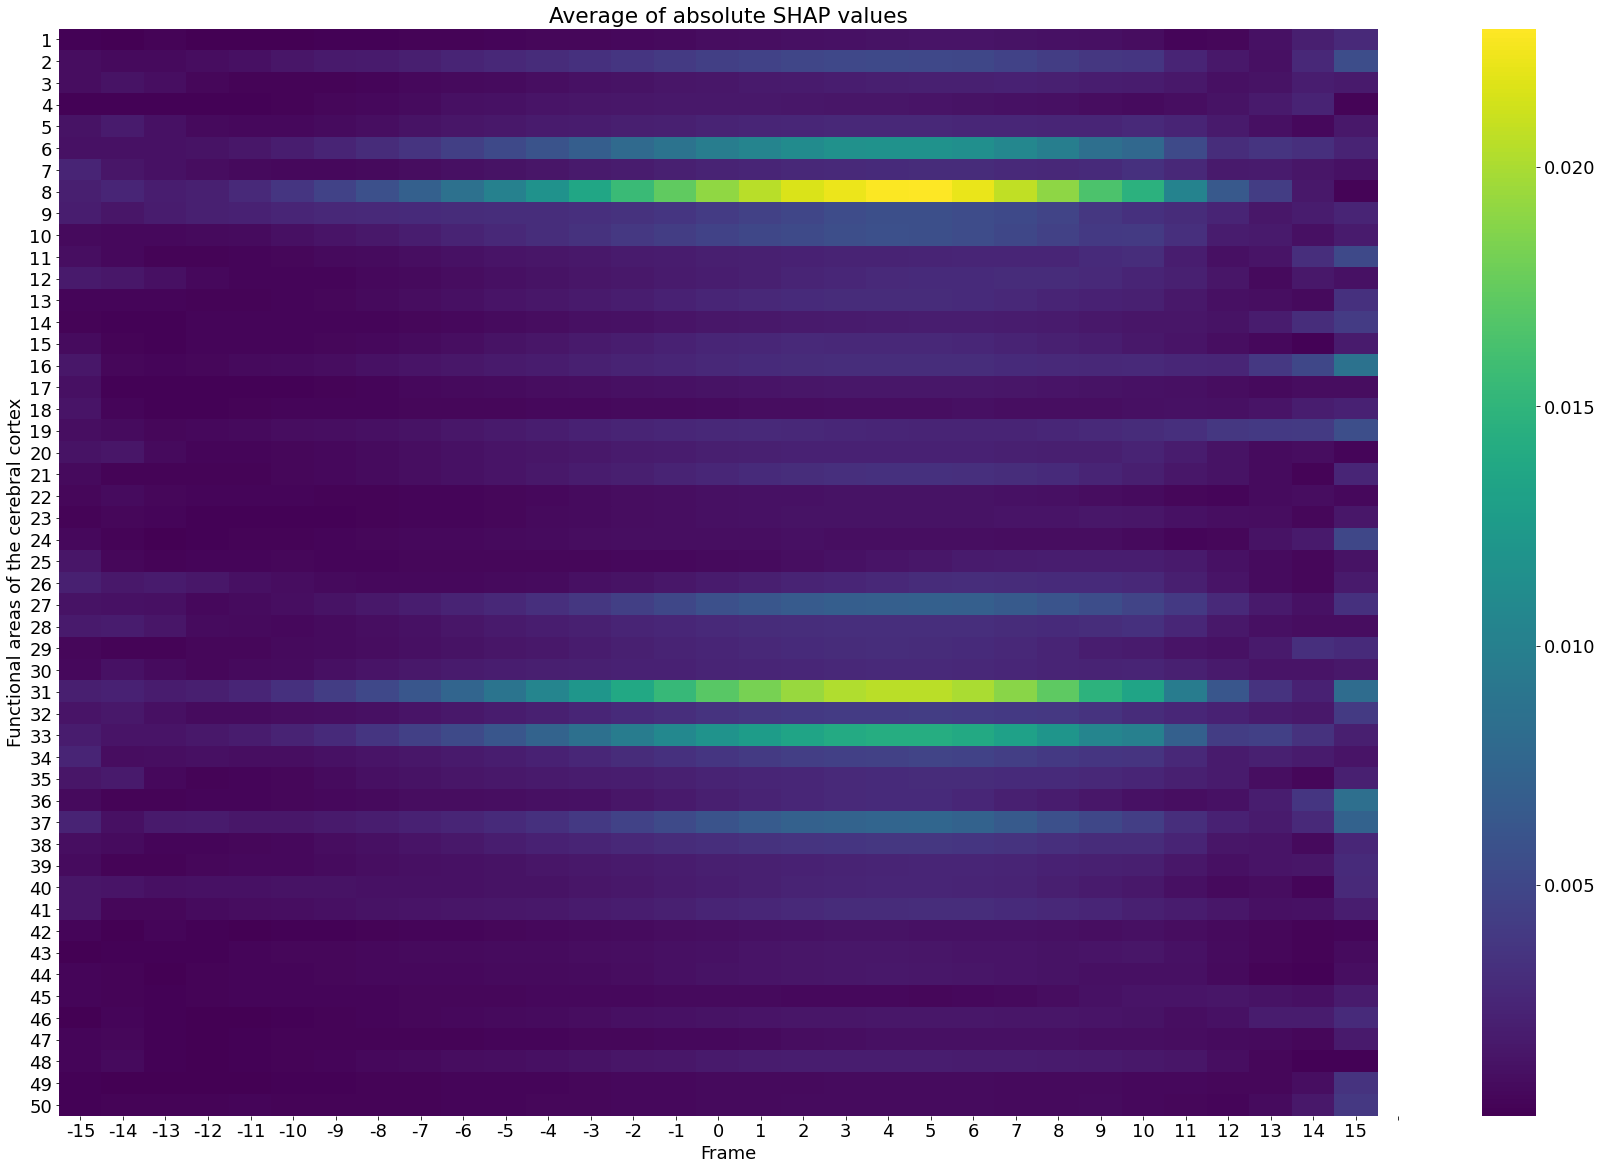

TEST
Mouse 5
The positive proportion is 0.94
The positive proportion is 0.95
The positive proportion is 0.83
The positive proportion is 0.77
The positive proportion is 0.78
The positive proportion is 0.75
The positive proportion is 0.80
The positive proportion is 0.78
The positive proportion is 0.85
The positive proportion is 0.72
The positive proportion is 0.82
The positive proportion is 0.64
0.81443906


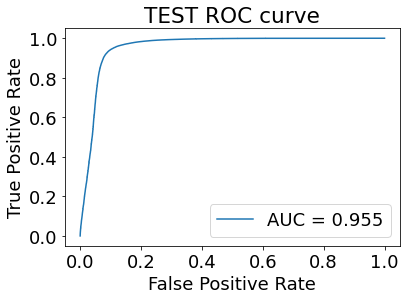

AUC: 0.955
Optimal threshold: 0.846
[120511 108566 110820 ...  37653 164319  83702]
(10000,)
Base: 0.8075594305992126



[0.98620683 0.98908036 0.99424988 ... 0.02252015 0.02097088 0.01564464]
[0.9862068  0.9890803  0.9942497  ... 0.02252007 0.02096999 0.01564425]


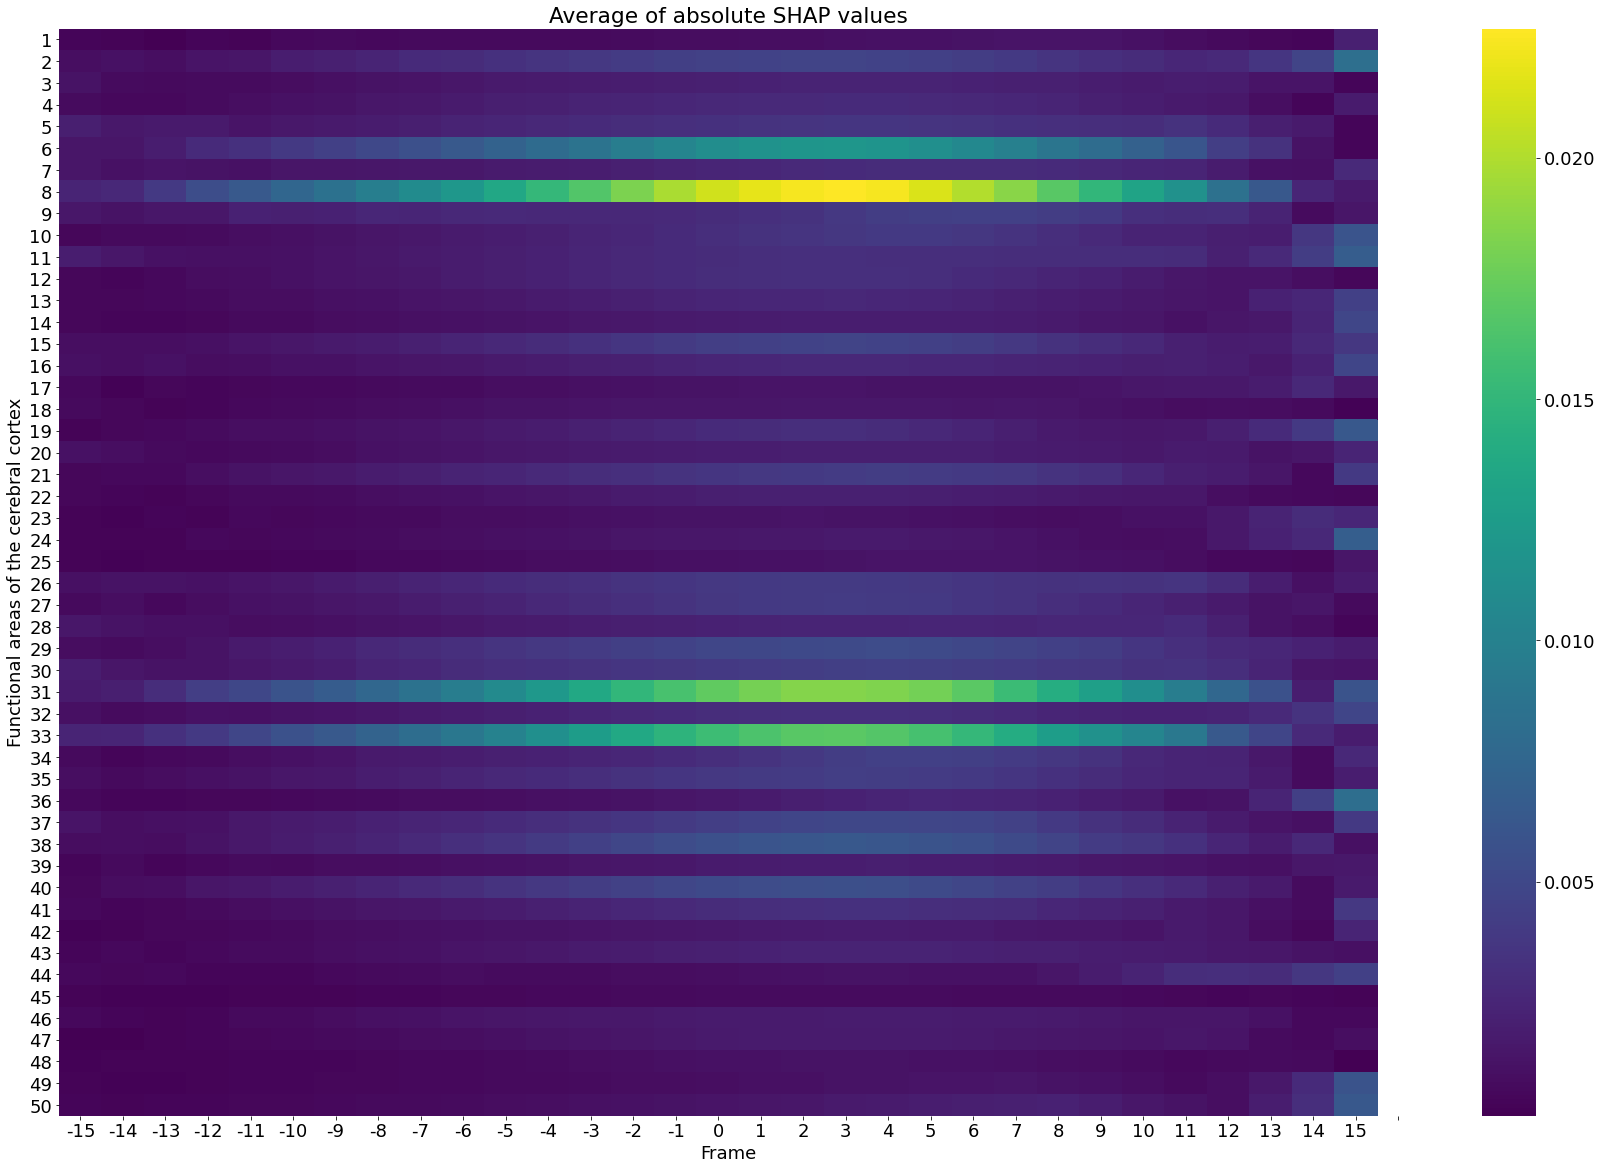

TEST
Mouse 5
The positive proportion is 0.94
The positive proportion is 0.95
The positive proportion is 0.83
The positive proportion is 0.77
The positive proportion is 0.78
The positive proportion is 0.75
The positive proportion is 0.80
The positive proportion is 0.78
The positive proportion is 0.85
The positive proportion is 0.72
The positive proportion is 0.82
The positive proportion is 0.64
0.8013792


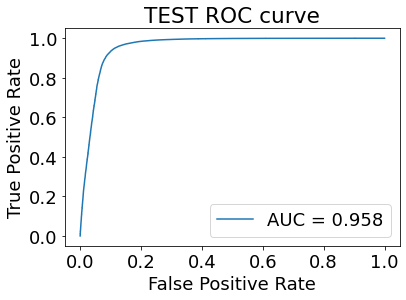

AUC: 0.958
Optimal threshold: 0.739
[ 82484  60233 145517 ... 101259 177113 145253]
(10000,)
Base: 0.8005313277244568



[0.83995712 0.91474617 0.96680818 ... 0.10206488 0.06523969 0.04020928]
[0.8399571  0.9147458  0.9668082  ... 0.10206479 0.06524089 0.04020903]


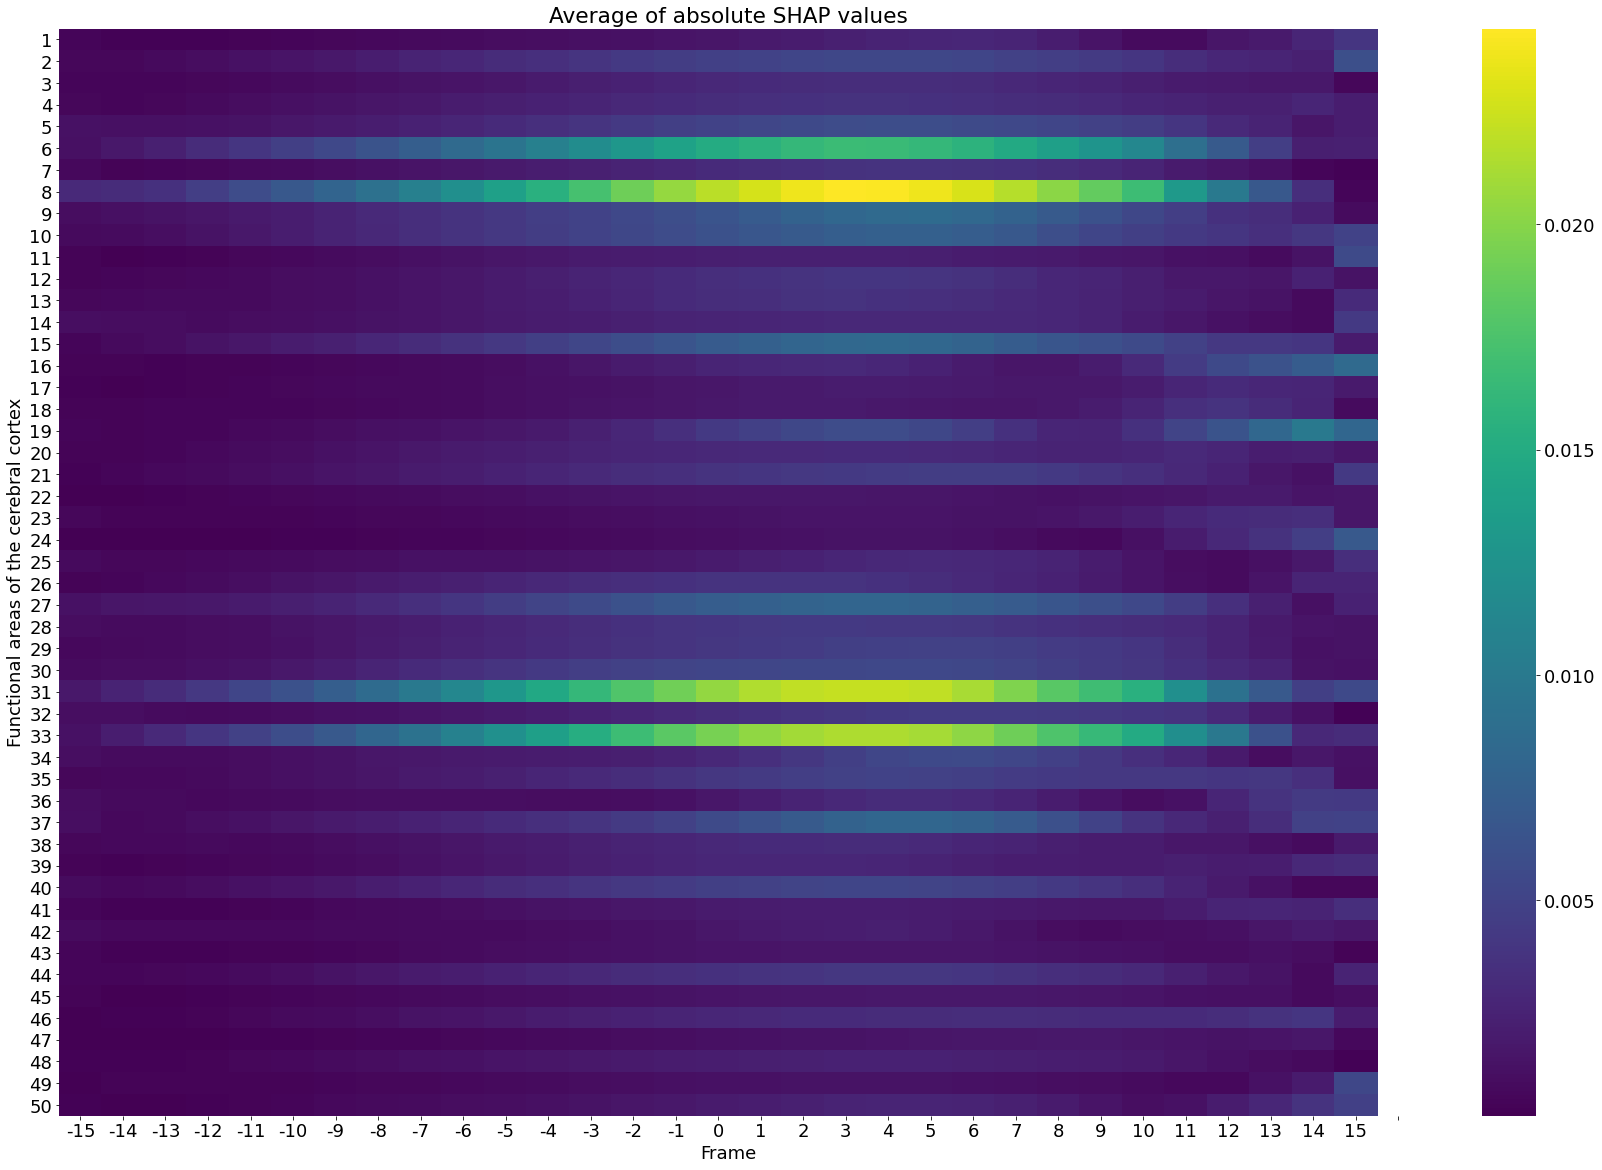

TEST
Mouse 5
The positive proportion is 0.94
The positive proportion is 0.95
The positive proportion is 0.83
The positive proportion is 0.77
The positive proportion is 0.78
The positive proportion is 0.75
The positive proportion is 0.80
The positive proportion is 0.78
The positive proportion is 0.85
The positive proportion is 0.72
The positive proportion is 0.82
The positive proportion is 0.64
0.81425387


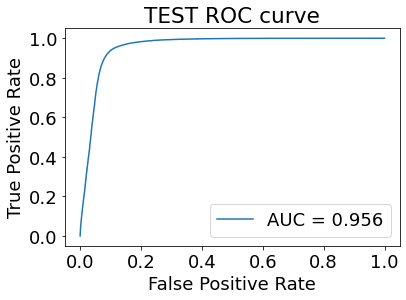

AUC: 0.956
Optimal threshold: 0.803
[ 43807 174796 149701 ...  15795 198013 189400]
(10000,)
Base: 0.8144571185112



[0.90551158 0.86903061 0.92447978 ... 0.01293768 0.0090037  0.00557634]
[0.90551186 0.8690307  0.9244797  ... 0.01293746 0.0090034  0.00557584]


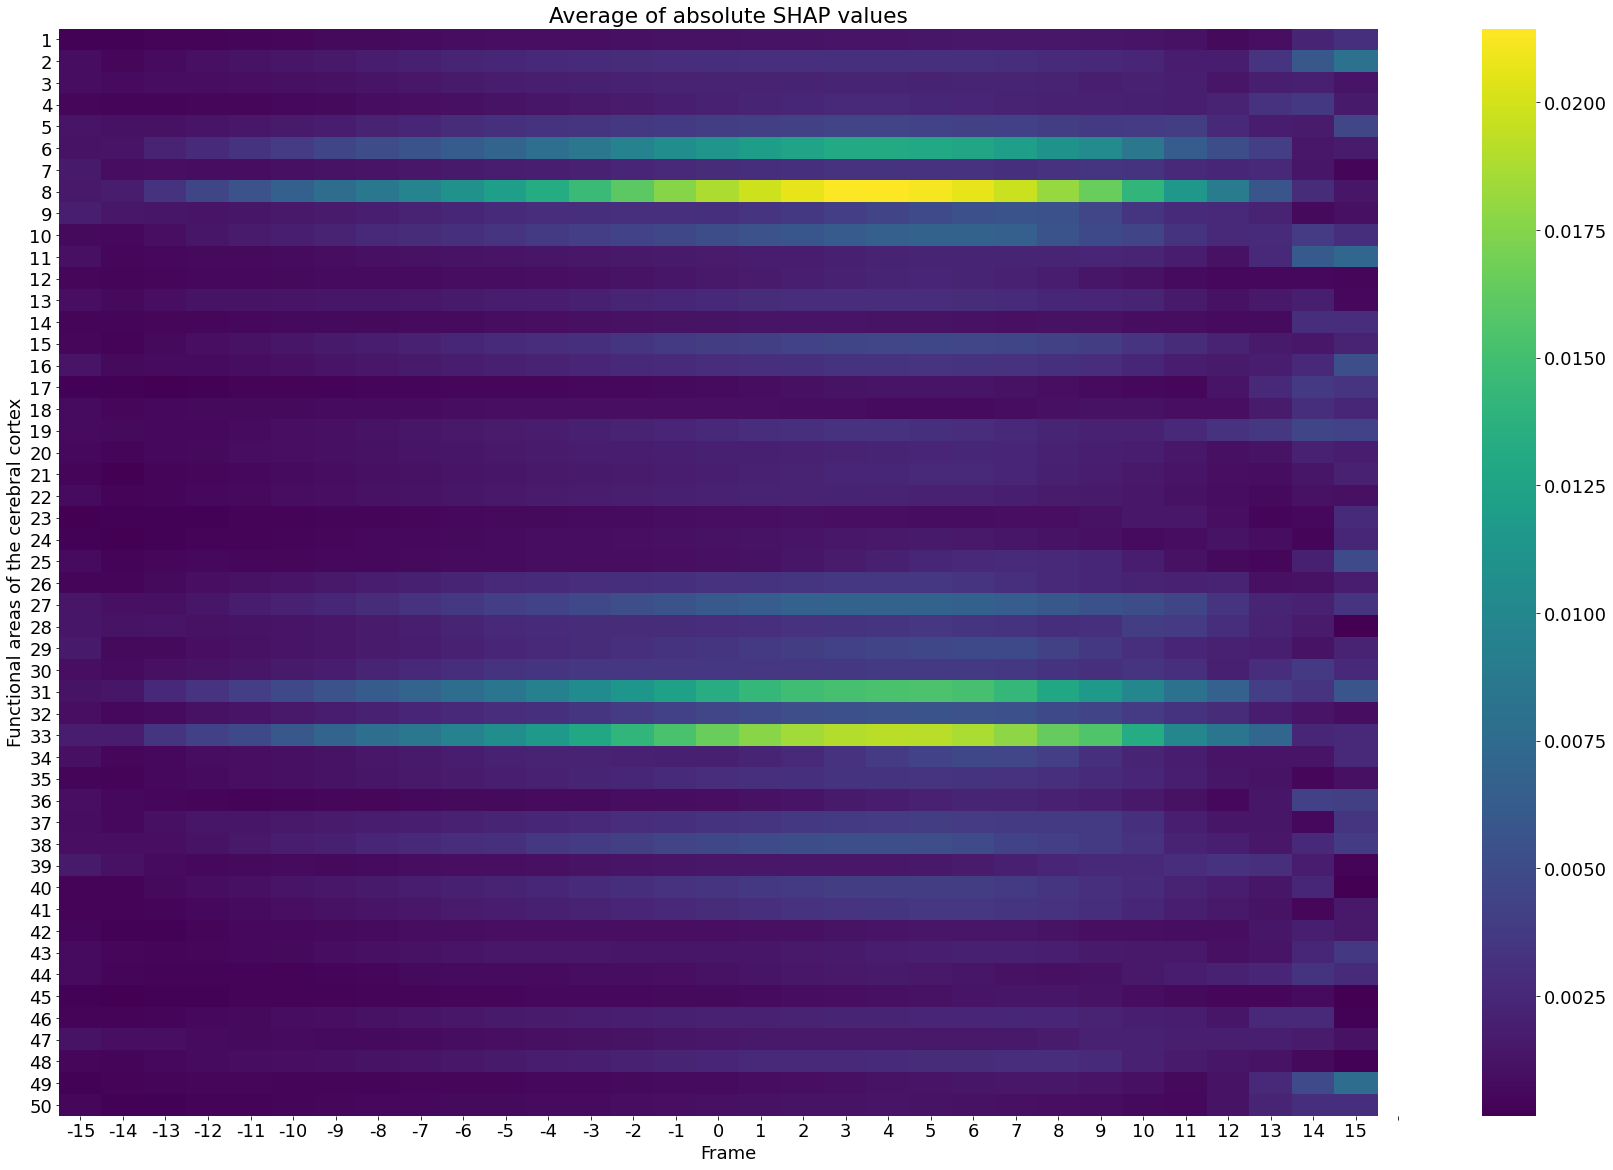

In [16]:
l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    testX, testY = Get_Dataset(TEST)
    input_test = testX.transpose(0,2,1)
    for ModelType in Models:
        ver = f'{ModelType}_{VALID}_{TEST}'
        model_file_path = f'models_N20/{ModelType}/best_model_{ver}.h5'
        model = load_model(model_file_path)
        test_pred = model.predict(input_test)
        print(test_pred.mean())
        plot_roc(test_pred, testY, "TEST")
        shap_val, base = calc_shap(input_test, test_pred, model)
        show_shap_abs_mean(shap_val)
        io.savemat(f"./shap/shap_{ver}.mat", {"base":base, "shap":shap_val, "pred":test_pred, "label":testY})